# Úvod 

![meme](https://miro.medium.com/v2/resize:fit:640/format:webp/0*-goJf0IOgPKdMvYG.jpg)

Tento dataset obsahuje **přibližně 210 000 zpravodajských titulků** z *[HuffPost](https://www.huffpost.com/)* za období 2012–2022. Jedná se o jeden z nejrozsáhlejších veřejně dostupných datových souborů, který slouží jako referenční benchmark pro různé úlohy **výpočetní lingvistiky**. *HuffPost* po roce 2018 přestal udržovat rozsáhlý archiv, proto již dnes nelze podobnou sadu dat zkompletovat znovu. V období **2012–květen 2018** je obsaženo asi *200 000 titulků*, mezi květnem 2018 a rokem 2022 pak přibližně *10 000*.

Odkaz na dataset skrze Kaggle: [News Category Dataset](https://www.kaggle.com/datasets/rmisra/news-category-dataset)

# Načtení knihoven

In [ ]:
from pathlib import Path
import re
import time
import os

import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import TFBertForSequenceClassification, BertTokenizer
from transformers import create_optimizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, TextVectorization, Flatten
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Input, LSTM, GRU, Bidirectional, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Reshape, Multiply, Lambda, TimeDistributed
from tensorflow.keras.layers import Softmax
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
from keras.layers import LeakyReLU
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, Dropout

# Nastavení pro reprodukci výsledků


In [3]:
seed = 42

tf.random.set_seed(seed)
np.random.seed(seed)

# Načtení dat

In [4]:
path = kagglehub.dataset_download("rmisra/news-category-dataset")

In [5]:
%ls ~/.cache/kagglehub/datasets/rmisra/news-category-dataset/versions/3

News_Category_Dataset_v3.json


In [6]:
json_file = Path(path) / "News_Category_Dataset_v3.json"

In [7]:
df = pd.read_json(json_file, lines=True)

In [8]:
df.head()

link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

# EDA

In [9]:
df.shape

(209527, 6)

In [10]:
df.describe()

date
count                         209527
mean   2015-04-30 00:44:14.344308736
min              2012-01-28 00:00:00
25%              2013-08-10 00:00:00
50%              2015-03-16 00:00:00
75%              2016-11-01 00:00:00
max              2022-09-23 00:00:00

## Názvy sloupců v datasetu

In [11]:
print('\n'.join(df.columns))

link
headline
category
short_description
authors
date


## Počet chybějících hodnot v každém sloupci

In [12]:
df.isnull().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

Žádný sloupec neobsahuje chybějící hodnoty. Paráda! 🎉

## Kontrola duplikátů

### Kontrola duplicitních hodnot pro každý sloupec

In [13]:
for column in df.columns:
    duplicated_values = df[column].duplicated().sum()
    print(f'Počet duplicitních hodnot ve sloupci {column:<20}: {duplicated_values:>8}')

Počet duplicitních hodnot ve sloupci link                :       41
Počet duplicitních hodnot ve sloupci headline            :     1531
Počet duplicitních hodnot ve sloupci category            :   209485
Počet duplicitních hodnot ve sloupci short_description   :    22505
Počet duplicitních hodnot ve sloupci authors             :   180358
Počet duplicitních hodnot ve sloupci date                :   205637


Dataset má **masivní duplicity v kategoriích, datech a autorech** (přes 180k), což je ale **naprosto normální**. 📰 Zpravodajské články logicky spadají do opakujících se kategorií a od stejných autorů. **Linky jsou skoro unikátní** (jen 41 duplicit ze 210k záznamů), 41 duplicitních linků pravděpodobně vzniklo kvůli aktualizacím článků, opravám nebo technickým chybám při scrapování. 🛠️ V každém případě jde o zanedbatelné množství (0,02%). Občasné opakování titulků a popisů také není problém, protože to ukazuje na ten fakt, že se podobné zprávy někdy publikovaly vícekrát od jiných autorů ve stejný čas. **Data jsou v pořádku pro analýzu.** ✅

### Počet duplicitních řádků

In [14]:
len(df[df.duplicated()])

13

Máme zde 13 duplicitních řádků, se kterými se vypořádáme odstraněním později.

## Unikátní hodnoty pro sloupec `category`

In [15]:
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [16]:
len(df.category.unique())

42

## Procentuální zastoupení všech kategorií

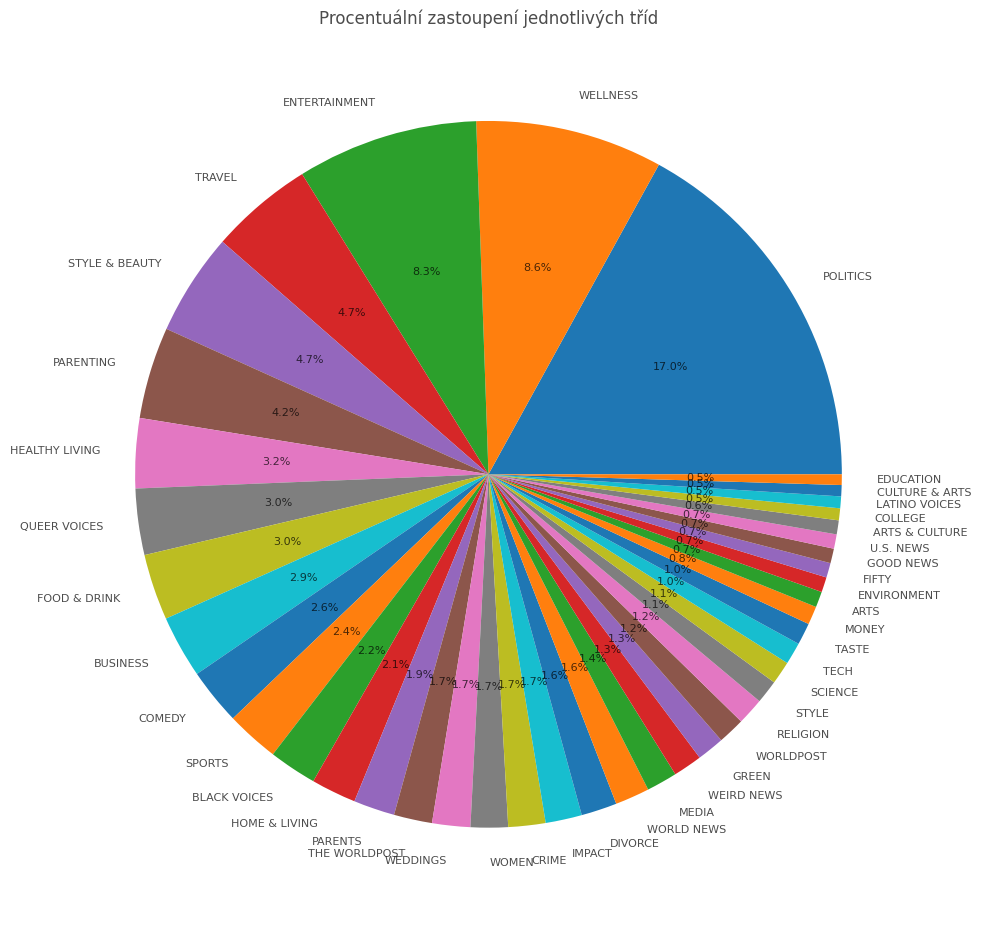

In [17]:
counts = df.category.value_counts()

plt.figure(figsize=(10, 10))
plt.pie(
    x=counts,
    labels=counts.index.tolist(),
    autopct='%1.1f%%',
    textprops={'fontsize': 8, 'alpha': .7}
)
plt.title("Procentuální zastoupení jednotlivých tříd", alpha=.7)
plt.tight_layout()

Woah, jak vidíme, dataset obsahuje již zmíněných **42** unikátních kategorií a sposuta z nich má velmi nízký počet článků. K tomu se dostaneme v další části, kde sloučíme kategorie s nízkým počtem článků do podobné kategorie s vyšším počtem článků.

## Top 10 kategorií

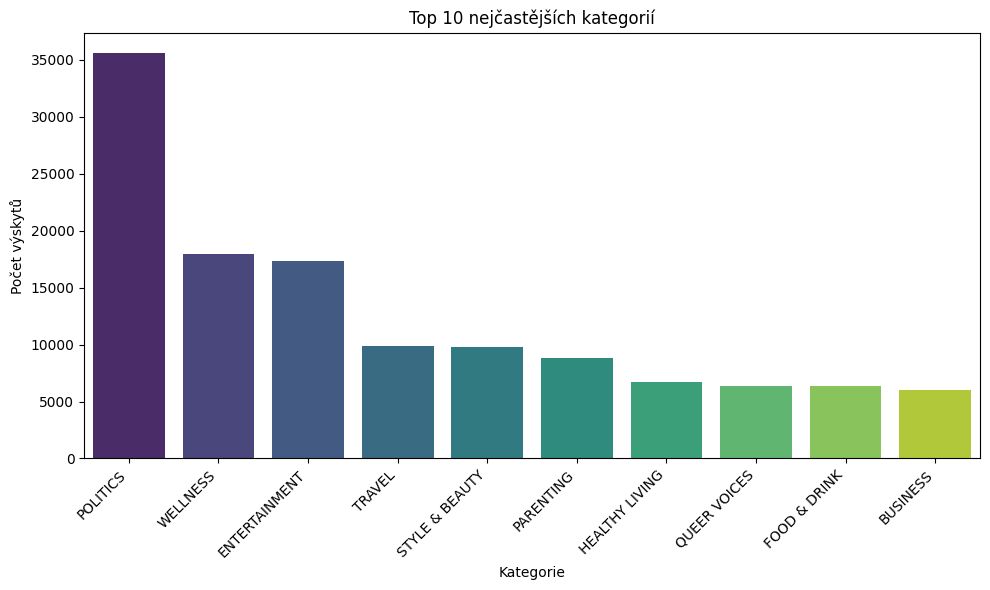

In [18]:
top_ten = counts.nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_ten.index,
    y=top_ten.values,
    hue=top_ten.index, 
    palette='viridis',
    legend=False  
)
plt.xticks(rotation=45, ha='right') 
plt.title("Top 10 nejčastějších kategorií")
plt.xlabel("Kategorie")
plt.ylabel("Počet výskytů")
plt.tight_layout()

**Politics** je velkým lákadlem pro čtenáře, což je vidět na masivní převaze článků v této kategorii. Následují kategorie **Wellness**, **Entertainment**, potom už je trend ve snižování počtu článků v jednotlivých kategoriích. 

## Wordcloud

Wordcloud ukazuje nejčastěji používaná slova v názvech článků. 📰 V politice se objevují slova jako **Trump**, **Obama**, **Republican**, **Democrat** a další, což odráží dobu, ve kterých byly články psány. Pojďme se podívat na pět nejčastějších kategorií a jejich *Wordcloud*. 🌟

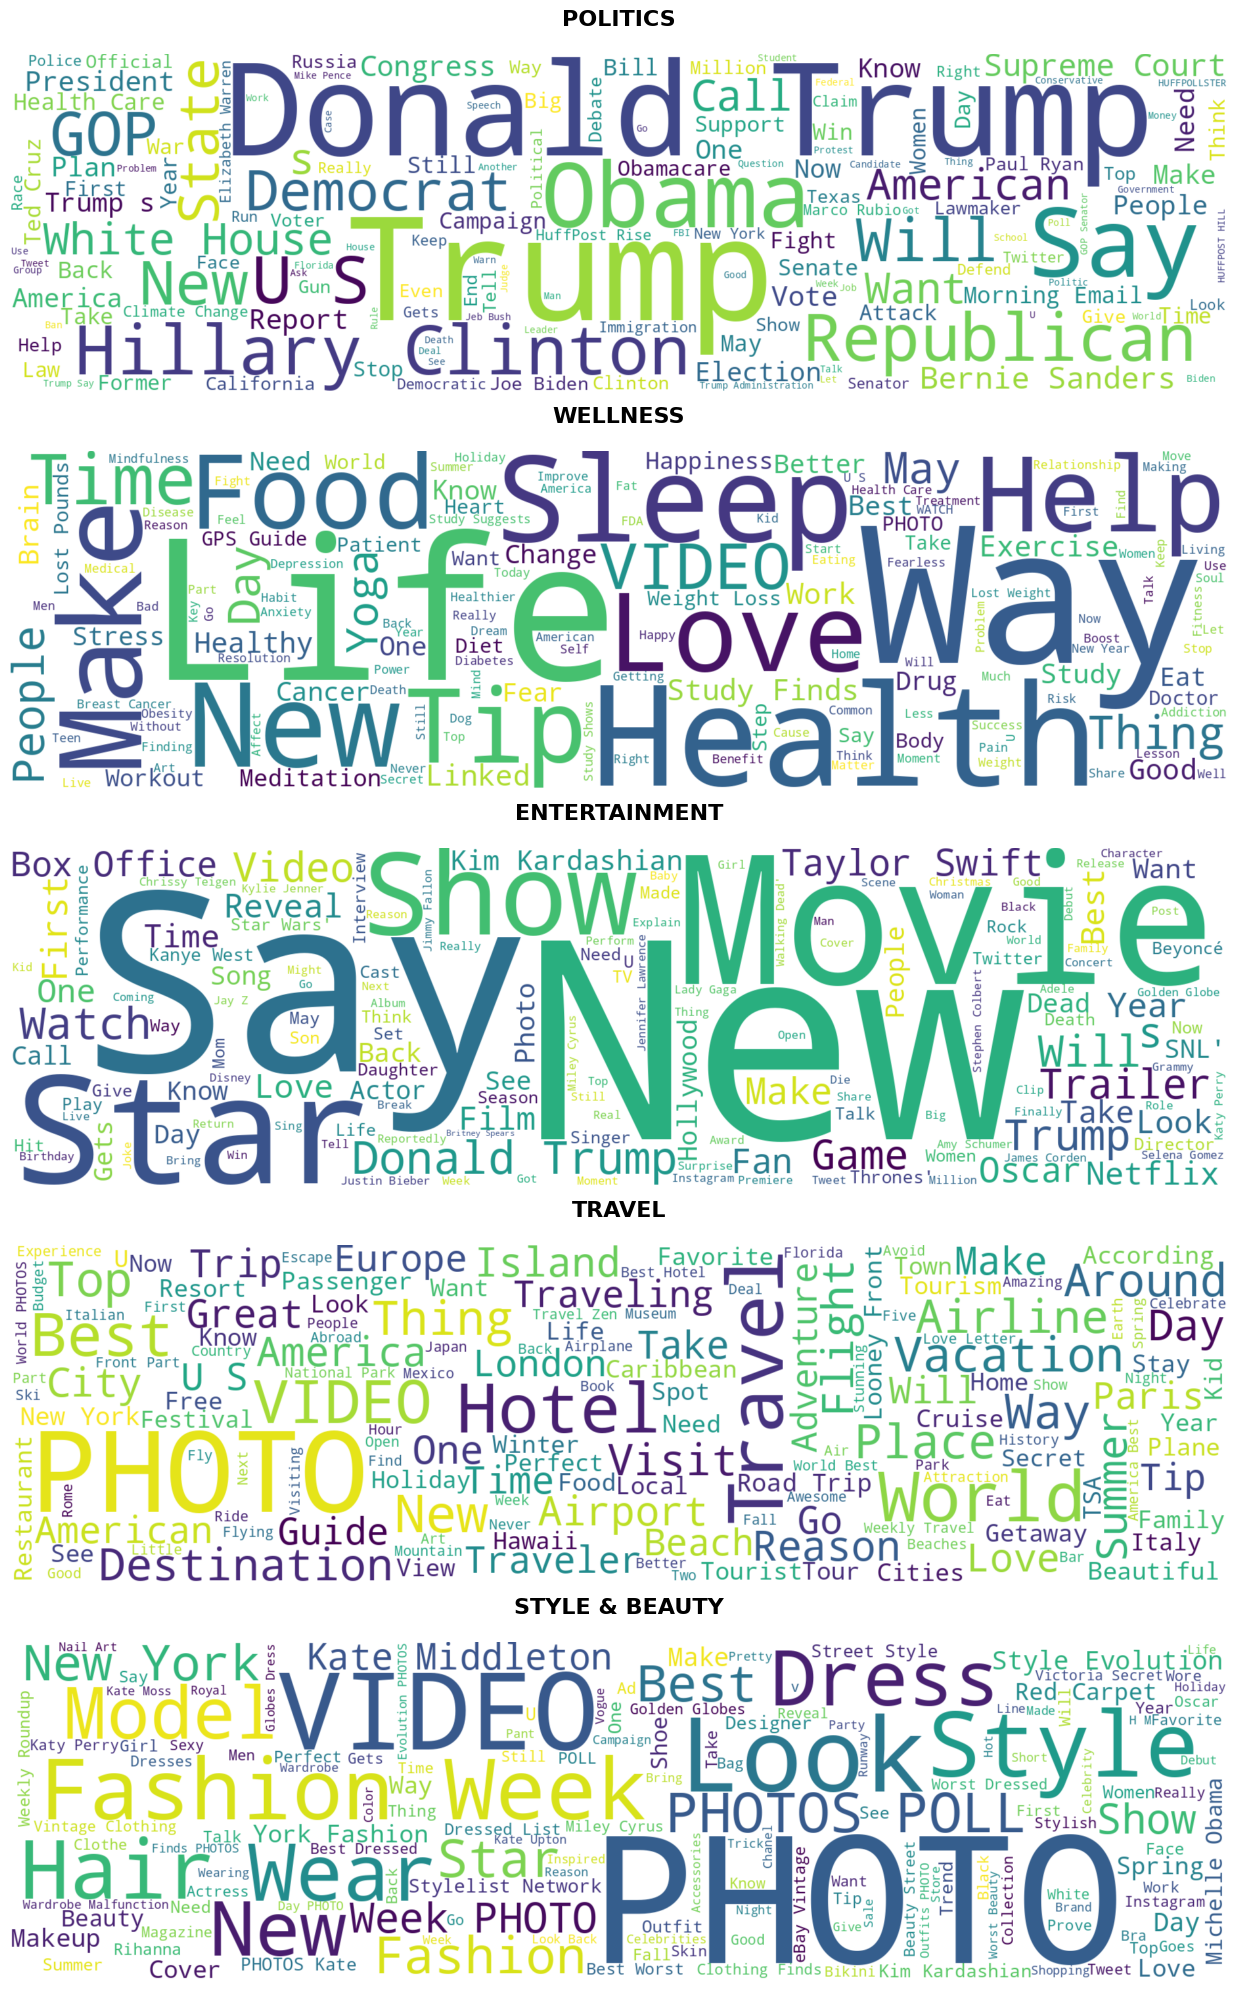

In [19]:
top5_categories = top_ten.head(5).index

fig, axes = plt.subplots(5, 1, figsize=(16, 20))
plt.subplots_adjust(hspace=1)

for ax, cat in zip(axes, top5_categories):
    headlines_text = ' '.join(df[df["category"] == cat]["headline"].dropna())
    wc = WordCloud(
        max_words=150,
        min_font_size=12,
        background_color="white",
        width=1800,  
        height=500, 
        colormap='viridis',
        stopwords=STOPWORDS
    )
    wc.generate(headlines_text)
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(cat, fontsize=16, fontweight='bold', pad=20)
    
plt.tight_layout()
plt.show()

## Délka titulků

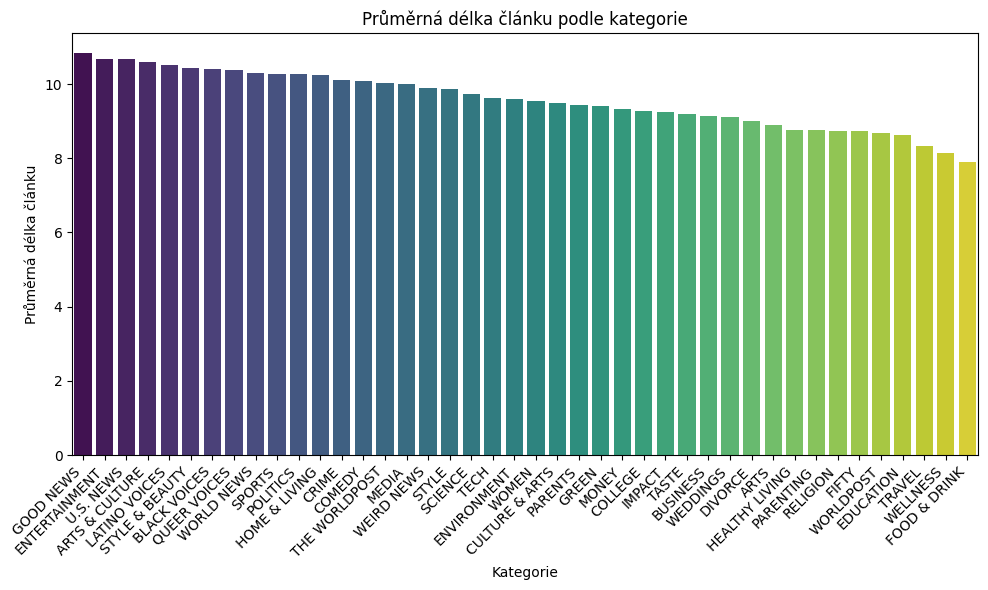

In [20]:
avg_lengths = df.groupby('category')['headline'].apply(lambda x: x.str.split().str.len().mean()).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=avg_lengths.index,
    y=avg_lengths.values,
    hue=avg_lengths.index, 
    palette='viridis',
    legend=False  
)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Kategorie")
plt.ylabel("Průměrná délka článku")
plt.title("Průměrná délka článku podle kategorie")
plt.tight_layout()

Poměr délky titulků ve všech kategoriích je velmi podobný, což ukazuje na dobře vybraný dataset.

# Předzpracování dat

In [21]:
df_modified = df.copy()
df_modified.head()

link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

## Zahození duplicitních řádků

In [22]:
print(f"Před odstraněním duplicitních hodnot: \t{len(df_modified)}")
df_modified = df_modified.drop_duplicates()
print(f"Po odstranění duplicitních hodnot: \t{len(df_modified)}")

Před odstraněním duplicitních hodnot: 	209527
Po odstranění duplicitních hodnot: 	209514


## Odstranění nepotřebných sloupců

`Link`, `Author` a `Date` sloupce nebudeme potřebovat, protože neobsahují žádné důležité informace pro analýzu. 

In [23]:
df_modified = df_modified[['headline', 'category', 'short_description']]
df_modified.head()

headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description  
0  Health experts said it is too early to predict...  
1  He was subdued by passengers and crew when he ...  
2  "Until you have a dog you don't understand wha...  
3  "Accidentally put grown-up toothpaste on my to...  
4  Amy Cooper accused investment firm Franklin Te...

## Sloučení podobných kategorií

Jak už bylo zmíněno, dataset obsahuje malé množství kategorií s velmi nízkým počtem článků. 📊 Tyto kategorie sloučíme do větších skupin, abychom zjednodušili analýzu a vizualizaci dat. 🔍 Například kategorie jako `Travel`, `Food & Drink` a `Lifestyle` mohou být sloučeny do jedné kategorie `Lifestyle`. 🏖️ Stejně tak jako dvě stejné kategorie `Culture & Arts` a `Art & Culture`. 🎨

In [24]:
category_mapping = {
    # NEWS & POLITICS 
    'U.S. NEWS': 'NEWS & POLITICS',
    'WORLD NEWS': 'NEWS & POLITICS',
    'THE WORLDPOST': 'NEWS & POLITICS',
    'WORLDPOST': 'NEWS & POLITICS',
    'POLITICS': 'NEWS & POLITICS',
    'CRIME': 'NEWS & POLITICS',
    'MEDIA': 'NEWS & POLITICS',
    'GOOD NEWS': 'NEWS & POLITICS',
    'WEIRD NEWS': 'NEWS & POLITICS',
    
    # BUSINESS & TECHNOLOGY
    'BUSINESS': 'BUSINESS & TECH',
    'MONEY': 'BUSINESS & TECH',
    'TECH': 'BUSINESS & TECH',
    
    # LIFESTYLE 
    'STYLE & BEAUTY': 'LIFESTYLE',
    'STYLE': 'LIFESTYLE',
    'FOOD & DRINK': 'LIFESTYLE',
    'TASTE': 'LIFESTYLE',
    'HOME & LIVING': 'LIFESTYLE',
    'TRAVEL': 'LIFESTYLE',
    'FIFTY': 'LIFESTYLE',
    'WEDDINGS': 'LIFESTYLE',
    
    # HEALTH & WELLNESS
    'WELLNESS': 'HEALTH & WELLNESS',
    'HEALTHY LIVING': 'HEALTH & WELLNESS',
    'GREEN': 'HEALTH & WELLNESS', 
    'ENVIRONMENT': 'HEALTH & WELLNESS',
    
    # ENTERTAINMENT
    'ENTERTAINMENT': 'ENTERTAINMENT',
    'COMEDY': 'ENTERTAINMENT',
    'SPORTS': 'ENTERTAINMENT',
    
    # CULTURE & ARTS
    'CULTURE & ARTS': 'CULTURE & ARTS',
    'ARTS': 'CULTURE & ARTS',
    'ARTS & CULTURE': 'CULTURE & ARTS',
    
    # FAMILY & SOCIAL
    'PARENTING': 'FAMILY & SOCIAL',
    'PARENTS': 'FAMILY & SOCIAL',
    'DIVORCE': 'FAMILY & SOCIAL',
    'WOMEN': 'FAMILY & SOCIAL',
    'QUEER VOICES': 'FAMILY & SOCIAL',
    'BLACK VOICES': 'FAMILY & SOCIAL',
    'LATINO VOICES': 'FAMILY & SOCIAL',
    
    # EDUCATION & SCIENCE
    'EDUCATION': 'EDUCATION & SCIENCE',
    'COLLEGE': 'EDUCATION & SCIENCE',
    'SCIENCE': 'EDUCATION & SCIENCE',
    
    # SOCIETY & IMPACT
    'RELIGION': 'SOCIETY & IMPACT',
    'IMPACT': 'SOCIETY & IMPACT'
}

df_modified['category_merged'] = df_modified['category'].map(category_mapping)

In [25]:
print(f"Počet původních kategorií: \t{len(df_modified['category'].unique())}")
print(f"Počet sloučených kategorií: \t{len(df_modified['category_merged'].unique())}")
print(f"\nCelková redukce: {len(df_modified['category'].unique())} → {len(df_modified['category_merged'].unique())} kategorií")

Počet původních kategorií: 	42
Počet sloučených kategorií: 	9

Celková redukce: 42 → 9 kategorií


In [26]:
print("Nové rozdělení kategorií:")
category_counts = df_modified['category_merged'].value_counts()
print(category_counts)
print("\nProcentuální rozdělení:")
for cat, count in category_counts.items():
    percentage = (count / len(df_modified)) * 100
    print(f"{cat}: {percentage:.1f}%")

Nové rozdělení kategorií:
category_merged
NEWS & POLITICS        57201
LIFESTYLE              39775
FAMILY & SOCIAL        31803
HEALTH & WELLNESS      28701
ENTERTAINMENT          27839
BUSINESS & TECH         9848
SOCIETY & IMPACT        6061
EDUCATION & SCIENCE     4364
CULTURE & ARTS          3922
Name: count, dtype: int64

Procentuální rozdělení:
NEWS & POLITICS: 27.3%
LIFESTYLE: 19.0%
FAMILY & SOCIAL: 15.2%
HEALTH & WELLNESS: 13.7%
ENTERTAINMENT: 13.3%
BUSINESS & TECH: 4.7%
SOCIETY & IMPACT: 2.9%
EDUCATION & SCIENCE: 2.1%
CULTURE & ARTS: 1.9%


Původních *42* kategorií bylo sloučeno do *9* hlavních skupin, což výrazně zjednodušilo analýzu dat a umožnilo přehlednější rozčlenění článků.  Například kategorie jako `CULTURE & ARTS`, která nyní obsahuje **3922 článků**, tvoří **1,9 %** z celkového počtu článků v datasetu.  Tato redukce kategorií nejen zlepšila vyváženost dat, ale také usnadnila další analýzu. I když rozdělení kategorií stále není ideální, je rozhodně lepší než původních 42 kategorií. 🚀

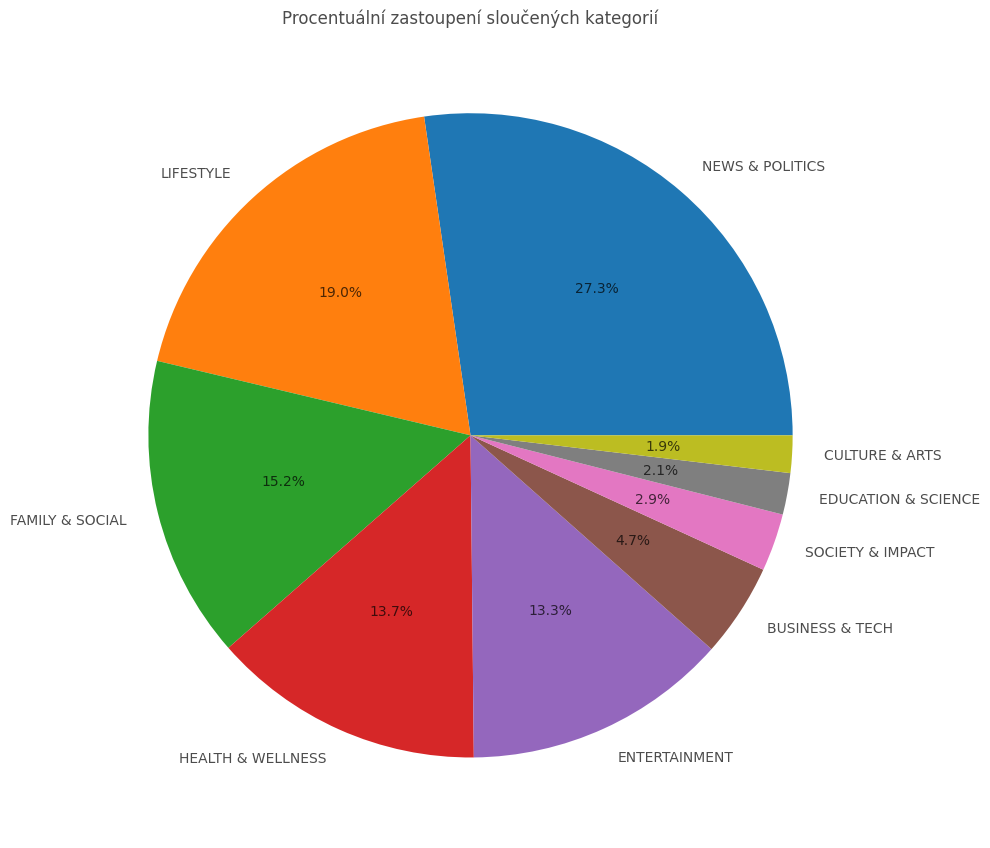

In [27]:
plt.figure(figsize=(10, 10))
plt.pie(
    x=category_counts,
    labels=category_counts.index.tolist(),
    autopct='%1.1f%%',
    textprops={'fontsize': 10, 'alpha': .7}
)
plt.title("Procentuální zastoupení sloučených kategorií", alpha=.7)
plt.tight_layout()

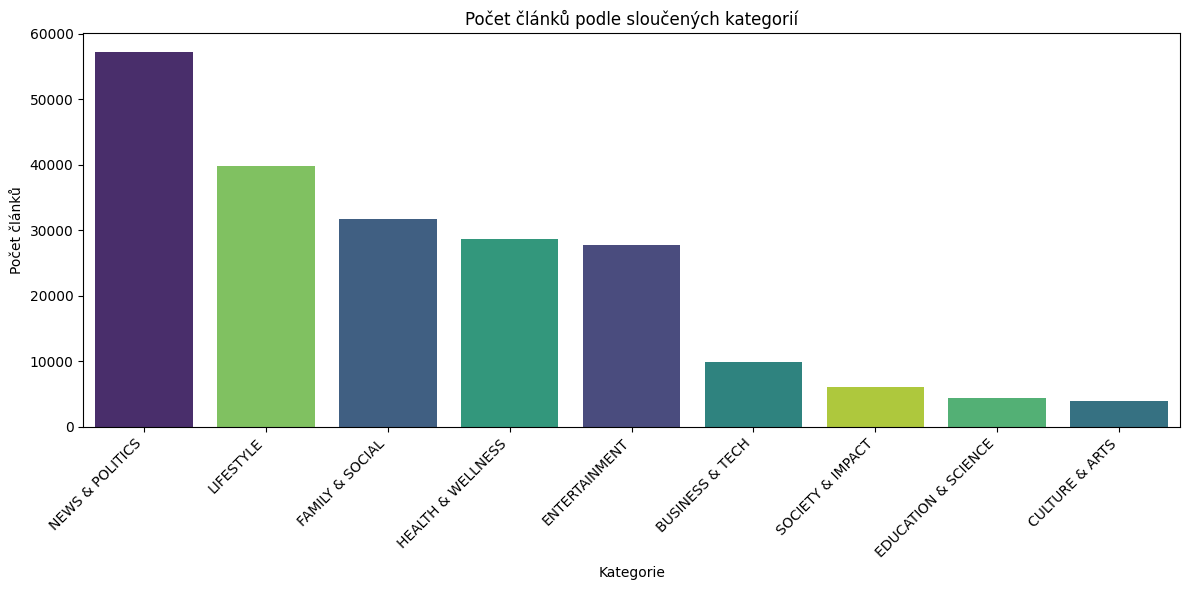

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_modified,
    x='category_merged',
    hue='category_merged',
    order=df_modified['category_merged'].value_counts().index,
    palette='viridis',
    legend=False
)
plt.xticks(rotation=45, ha='right')
plt.title("Počet článků podle sloučených kategorií")
plt.xlabel("Kategorie")
plt.ylabel("Počet článků")
plt.tight_layout()

### Zvolená metrika

Vzhledem k nerovnosti jednotlivých kategorií a jejich nízkému počtu článků bude nejlepší metrikou pro hodnocení modelů **F1-score**. Bere v úvahu vyváženost mezi oběma třídami a je vhodná pro nevyvážené dataset, jako je tento.

## Nový `all` sloupec

Vytvoříme nový sloupec, který nazveme jako `all`, který sloučí **titulek** a **popis** článku do jednoho sloupce. Tento sloupec bude sloužit jako náš `target` pro další analýzu a modelování. Díky tomu dostaneme klíčovou infomaci o obsahu článku hned na začátku a zbytek textu by měl navazovat na tento obsah. Tímto způsobem získáme lepší kontext pro další zpracování a analýzu textu.

In [29]:
df_modified["all"] = df_modified["headline"] + " " + df_modified["short_description"]
df_modified

headline   category  \
0       Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1       American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2       23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3       The Funniest Tweets From Parents This Week (Se...  PARENTING   
4       Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   
...                                                   ...        ...   
209522  RIM CEO Thorsten Heins' 'Significant' Plans Fo...       TECH   
209523  Maria Sharapova Stunned By Victoria Azarenka I...     SPORTS   
209524  Giants Over Patriots, Jets Over Colts Among  M...     SPORTS   
209525  Aldon Smith Arrested: 49ers Linebacker Busted ...     SPORTS   
209526  Dwight Howard Rips Teammates After Magic Loss ...     SPORTS   

                                        short_description  category_merged  \
0       Health experts said it is too early to predict...  NEWS & POLITICS   
1       He was subdued by passengers and crew when he ...  NEWS & POLITICS   
2       "Until you have a dog you don't understand wha...    ENTERTAINMENT   
3       "Accidentally put grown-up toothpaste on my to...  FAMILY & SOCIAL   
4       Amy Cooper accused investment firm Franklin Te...  NEWS & POLITICS   
...                                                   ...              ...   
209522  Verizon Wireless and AT&T are already promotin...  BUSINESS & TECH   
209523  Afterward, Azarenka, more effusive with the pr...    ENTERTAINMENT   
209524  Leading up to Super Bowl XLVI, the most talked...    ENTERTAINMENT   
209525  CORRECTION: An earlier version of this story i...    ENTERTAINMENT   
209526  The five-time all-star center tore into his te...    ENTERTAINMENT   

                                                      all  
0       Over 4 Million Americans Roll Up Sleeves For O...  
1       American Airlines Flyer Charged, Banned For Li...  
2       23 Of The Funniest Tweets About Cats And Dogs ...  
3       The Funniest Tweets From Parents This Week (Se...  
4       Woman Who Called Cops On Black Bird-Watcher Lo...  
...                                                   ...  
209522  RIM CEO Thorsten Heins' 'Significant' Plans Fo...  
209523  Maria Sharapova Stunned By Victoria Azarenka I...  
209524  Giants Over Patriots, Jets Over Colts Among  M...  
209525  Aldon Smith Arrested: 49ers Linebacker Busted ...  
209526  Dwight Howard Rips Teammates After Magic Loss ...  

[209514 rows x 5 columns]

## Čištění textu

### Odstranění speciálních znaků a čísel ✂️🔢
- odstraníme speciální znaky a čísla z textu, aby zůstal pouze čistý text 🧹
- převedeme text na malá písmena, aby se zjednodušila analýza a porovnávání slov 🔡
- odstraníme nadbytečné mezery, které mohou vzniknout při odstraňování speciálních znaků a čísel 🚀

In [30]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    text = text.lower()  
    text = text.strip()
    return text

In [31]:
df_modified["headline"] = df_modified["headline"].apply(clean_text)
df_modified["short_description"] = df_modified["short_description"].apply(clean_text)
df_modified["all"] = df_modified["all"].apply(clean_text)

### Stopslova

Stopslova jsou slova, která nemají žádný význam pro analýzu textu a mohou být odstraněna. Například slova jako `the`, `and`, `is`, `to`, `of` a další. Tato slova neobsahují žádnou informaci o obsahu článku a mohou být odstraněna, aby se zjednodušil text a zlepšila přesnost modelů. 

In [32]:
stop_words = set(stopwords.words('english')) | set(STOPWORDS)

df_modified["headline"] = df_modified["headline"].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

df_modified["short_description"] = df_modified["short_description"].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

df_modified["all"] = df_modified["all"].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

### Lemmatizace

Lemmatizace je proces, který převádí slova na jejich základní tvar. Například slovo `running` bude převedeno na `run`, což zjednoduší analýzu textu a sníží počet unikátních slov v textu a tím pádem i zlepší přesnost modelů.

In [33]:
lemmatizer = WordNetLemmatizer()

df_modified["headline"] = df_modified["headline"].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

df_modified["short_description"] = df_modified["short_description"].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

df_modified["all"] = df_modified["all"].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)

# Trénování modelů

## Příprava dat pro trénování modelů

### Rozdělení dat na trénovací a testovací sadu

In [34]:
X = df_modified['all']
y = df_modified['category_merged']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)

print(f"Velikost trénovacích dat: {X_train.shape}")
print(f"Velikost testovacích dat: {X_test.shape}")

Velikost trénovacích dat: (167611,)
Velikost testovacích dat: (41903,)


### Tokenizace & Padding

In [35]:
VOCAB_SIZE = 10_000    # Počet nejčastějších slov, která chceme zachovat
SEQ_LENGTH = 128       # Maximální délka sekvence

In [36]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

# Převod textu na sekvence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Doplnění sekvencí na jednotnou délku
X_train_pad = pad_sequences(X_train_seq, maxlen=SEQ_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=SEQ_LENGTH, padding='post', truncating='post')

# Převod cílových proměnných na číselné kategorie
X_train_pad = np.array(X_train_pad, dtype=np.int32)
X_test_pad = np.array(X_test_pad, dtype=np.int32)

print(f"Tvar doplněných trénovacích dat: {X_train_pad.shape}")
print(f"Tvar doplněných testovacích dat: {X_test_pad.shape}")
print(f"Velikost slovníku: {len(tokenizer.word_index)}")

Tvar doplněných trénovacích dat: (167611, 128)
Tvar doplněných testovacích dat: (41903, 128)
Velikost slovníku: 89656


### Label encoding

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Převod na kategorické (one-hot encoding)
NUM_CLASSES = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_encoded, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test_encoded, num_classes=NUM_CLASSES)

print(f"Počet tříd: {NUM_CLASSES}")
print(f"Tvar zakódovaného trénovacího cíle: {y_train_cat.shape}")
print(f"Tvar zakódovaného testovacího cíle: {y_test_cat.shape}")
print(f"Mapování tříd: {dict(zip(label_encoder.classes_, range(NUM_CLASSES)))}")

Počet tříd: 9
Tvar zakódovaného trénovacího cíle: (167611, 9)
Tvar zakódovaného testovacího cíle: (41903, 9)
Mapování tříd: {'BUSINESS & TECH': 0, 'CULTURE & ARTS': 1, 'EDUCATION & SCIENCE': 2, 'ENTERTAINMENT': 3, 'FAMILY & SOCIAL': 4, 'HEALTH & WELLNESS': 5, 'LIFESTYLE': 6, 'NEWS & POLITICS': 7, 'SOCIETY & IMPACT': 8}


## Pomocné funkce

### Vyhodnocení modelu

In [38]:
def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    report = classification_report(
        y_true, 
        y_pred, 
        target_names=label_encoder.classes_,
        zero_division=0
    )
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"F1 skóre (vážené): {f1:.4f}")
    print("\nKlasifikační zpráva:")
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predikováno')
    plt.ylabel('Skutečné')
    plt.title(f'Matice záměn (F1: {f1:.4f})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return f1, report

### Vytvoření embedding vrstvy

In [39]:
EMBEDING_DIM = 200

#### Custom embedding layer

In [40]:
def in_emb_layers(words):
    input_layer = Input(shape=(1,), dtype=tf.string)

    vectorization = TextVectorization(max_tokens=VOCAB_SIZE,
                                      output_mode='int',
                                      output_sequence_length=SEQ_LENGTH)
    vectorization.adapt(words)
    vec = vectorization(input_layer)
    emb = Embedding(VOCAB_SIZE, EMBEDING_DIM)(vec)

    return input_layer, emb

#### GloVe embedding layer

In [41]:
if not os.path.exists('data/glove/glove.6B.zip') and not os.path.exists('data/glove/glove.6B.50d.txt'):
    print("Downloading GloVe embeddings...")
    os.makedirs('data/glove', exist_ok=True)
    !wget http://nlp.stanford.edu/data/glove.6B.zip -P data/glove/
else:
    print("GloVe embeddings already downloaded.")

GloVe embeddings already downloaded.


In [42]:
if os.path.exists('data/glove/glove.6B.zip') and not os.path.exists('data/glove/glove.6B.50d.txt'):
    print("Extracting GloVe embeddings...")
    !unzip -q data/glove/glove.6B.zip -d data/glove/
else:
    print("GloVe embeddings already extracted.")

GloVe embeddings already extracted.


In [43]:
def glove_im_emb_tokenized(input_shape=(SEQ_LENGTH,)):
	path_to_glove_file = f'data/glove/glove.6B.{EMBEDING_DIM}d.txt'

	embeddings_index = {}
	with open(path_to_glove_file) as f:
		for line in f:
			word, coefs = line.split(maxsplit=1)
			coefs = np.fromstring(coefs, "f", sep=" ")
			embeddings_index[word] = coefs

	word_index = tokenizer.word_index
	
	num_tokens = min(VOCAB_SIZE, len(word_index) + 1)
	embedding_matrix = np.zeros((num_tokens, EMBEDING_DIM))
	
	hits = 0
	misses = 0
	
	for word, i in word_index.items():
		if i >= VOCAB_SIZE:
			continue
		embedding_vector = embeddings_index.get(word)
		if embedding_vector is not None:
			embedding_matrix[i] = embedding_vector
			hits += 1
		else:
			misses += 1
	
	print(f"GloVe vektory: {hits} nalezeno a {misses} chybí")
	embed_init = Constant(embedding_matrix)
	
	input_layer = Input(shape=input_shape)
	
	emb = Embedding(
			num_tokens,
			EMBEDING_DIM,
			embeddings_initializer=embed_init,
			trainable=False)(input_layer)

	return input_layer, emb

## Samoté trénování modelů

In [44]:
EPOCHS = 10
BATCH_SIZE = 64
PATIENCE = EPOCHS // 2 # brzké zastavení trénování nastavené na polovinu epoch
VALIDATION_SPLIT = 0.2

### Vlastní modely

#### Vlastní embedding vrstva

##### Model 1

Tento model slouží jako jednoduchý základ pro zpracování sekvenčních dat. 🧠

- **Embedding vrstva**: Převádí vstupní tokeny na husté vektory. 🧩
- **Rekurentní vrstvy**: Kombinace LSTM a GRU pro zachycení časových závislostí. 🔄
- **Zahušťování**: Flatten + Dense vrstvy pro extrakci příznaků. 📊
- **Regularizace**: Dropout vrstva s 20% pravděpodobností. 🎯
- **Výstup**: Softmax klasifikace do zadaného počtu tříd. 🏷️
- **Optimalizace**: RMSprop a ztrátová funkce pro vícetřídovou klasifikaci. ⚙️

In [ ]:
def custom_embedding_1(input_shape, num_classes=9):
    input_layer = Input(shape=input_shape)
    
    emb = Embedding(VOCAB_SIZE, EMBEDING_DIM)(input_layer)
    
    x = LSTM(64, activation='relu', return_sequences=True)(emb)
    x = GRU(64, activation='relu', return_sequences=True)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(input_layer, output)
    
    model.compile(
            optimizer=RMSprop(),
            loss=CategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

    return model

In [46]:
model_1 = custom_embedding_1((SEQ_LENGTH,), NUM_CLASSES)
model_1.summary()

I0000 00:00:1748872600.993324   35713 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 64)        │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,529 (9.99 MB)

 Trainable params: 2,619,529 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
start_time = time.time()
history_1 = model_1.fit(
    X_train_pad, 
    y_train_cat, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]
)
time_taken_1 = time.time() - start_time
print(f"Trénování modelu 1 trvalo {time_taken_1:.2f} sekund.")

Epoch 1/10


I0000 00:00:1748872605.237045   35980 service.cc:152] XLA service 0x730b240050d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748872605.237098   35980 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-06-02 15:56:45.353466: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748872605.972826   35980 cuda_dnn.cc:529] Loaded cuDNN version 90501


   1/2096 ━━━━━━━━━━━━━━━━━━━━ 5:10:05 9s/step - accuracy: 0.0938 - loss: 2.2008

I0000 00:00:1748872611.436029   35980 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2096/2096 ━━━━━━━━━━━━━━━━━━━━ 167s 75ms/step - accuracy: 0.4236 - loss: 84799152.0000 - val_accuracy: 0.6852 - val_loss: 0.9958
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 162s 77ms/step - accuracy: 0.6950 - loss: 12.9844 - val_accuracy: 0.7176 - val_loss: 0.8977
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 165s 79ms/step - accuracy: 0.7327 - loss: 0.8574 - val_accuracy: 0.7214 - val_loss: 0.8723
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 164s 78ms/step - accuracy: 0.7526 - loss: 0.7928 - val_accuracy: 0.7289 - val_loss: 0.8582
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 167s 80ms/step - accuracy: 0.7670 - loss: 0.7443 - val_accuracy: 0.7305 - val_loss: 0.8571
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 167s 80ms/step - accuracy: 0.7797 - loss: 0.7052 - val_accuracy: 0.7249 - val_loss: 0.8957
Epoch 7/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 166s 79ms/step - accuracy: 0.7908 - loss: 0.6738 - val_accuracy: 0.7265 - val_loss: 0.9490
Epoch 8/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 162s 77ms/step - accuracy: 0.8

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
F1 skóre (vážené): 0.7205

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.52      0.62      0.56      1970
     CULTURE & ARTS       0.54      0.40      0.46       784
EDUCATION & SCIENCE       0.52      0.38      0.44       873
      ENTERTAINMENT       0.70      0.74      0.72      5568
    FAMILY & SOCIAL       0.70      0.63      0.66      6361
  HEALTH & WELLNESS       0.70      0.72      0.71      5740
          LIFESTYLE       0.77      0.84      0.80      7955
    NEWS & POLITICS       0.80      0.81      0.80     11440
   SOCIETY & IMPACT       0.58      0.26      0.36      1212

           accuracy                           0.73     41903
          macro avg       0.65      0.60      0.61     41903
       weighted avg       0.72      0.73      0.72     41903



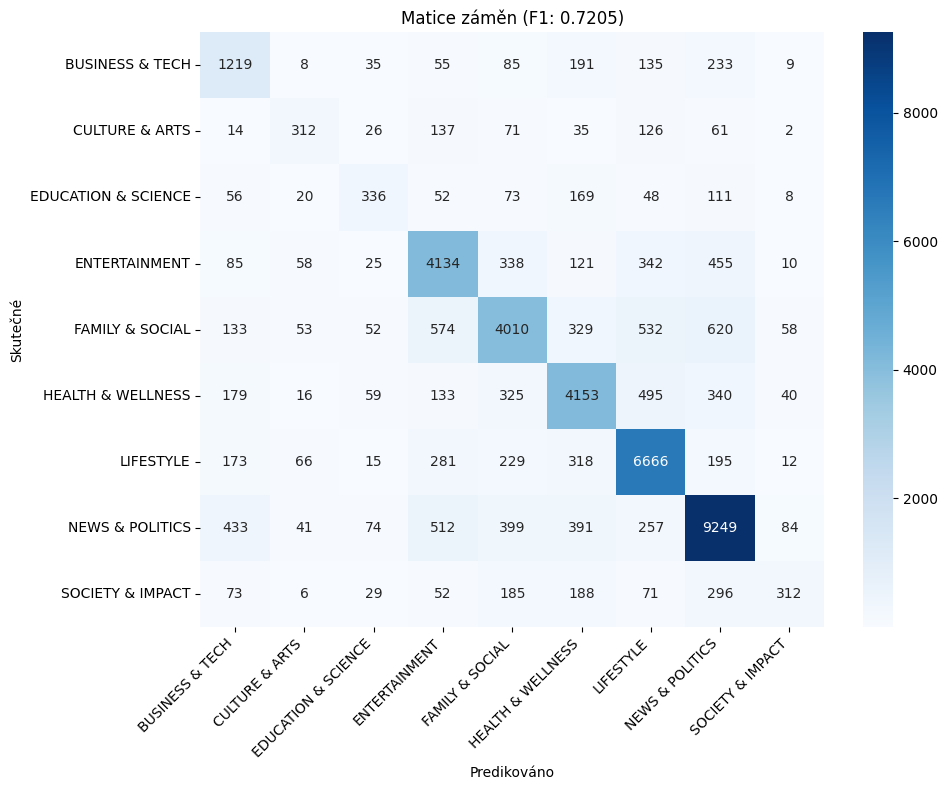

In [48]:
f1_1, report_1 = evaluate_model(model_1, X_test_pad, y_test_cat, label_encoder)

##### Model 2 

Tento model rozšiřuje předchozí základní verzi o vyšší kapacitu a lepší regularizaci. 🚀

Klíčová vylepšení:
- **Větší rekurentní vrstvy**: LSTM a GRU mají 128 jednotek místo 64 → více prostoru pro učení složitějších závislostí. 🧠
- **Více Dense vrstev**: Přidány dvě nové Dense vrstvy (128 a 64 jednotek) → hlubší zpracování extrahovaných příznaků. 📊
- **Intenzivnější regularizace**: Tři Dropout vrstvy (každá 0.2) → snížení přeučení. 🎯

In [49]:
def custom_embedding_2(input_shape, num_classes=9):
    input_layer = Input(shape=input_shape)
    emb = Embedding(VOCAB_SIZE, EMBEDING_DIM)(input_layer)
    
    x = LSTM(128, activation='relu', return_sequences=True)(emb)
    x = GRU(128, activation='relu', return_sequences=True)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(input_layer, output)
    
    model.compile(
            optimizer=RMSprop(),
            loss=CategoricalCrossentropy(from_logits=False),
            metrics=['accuracy'])

    return model

In [50]:
model_2 = custom_embedding_2((SEQ_LENGTH,), NUM_CLASSES)
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 128, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128, 128)       │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,390,153 (16.75 MB)

 Trainable params: 4,390,153 (16.75 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
start_time = time.time()
history_2 = model_2.fit(
    X_train_pad, 
    y_train_cat, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]
)
time_taken_2 = time.time() - start_time
print(f"Trénování modelu 2 trvalo {time_taken_2:.2f} sekund.")

Epoch 1/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 180s 81ms/step - accuracy: 0.4245 - loss: 2420029440.0000 - val_accuracy: 0.6636 - val_loss: 1.0399
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 167s 79ms/step - accuracy: 0.6946 - loss: 0.9828 - val_accuracy: 0.7167 - val_loss: 0.8966
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 164s 78ms/step - accuracy: 0.7316 - loss: 0.8599 - val_accuracy: 0.7233 - val_loss: 0.8663
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 161s 77ms/step - accuracy: 0.7524 - loss: 0.7994 - val_accuracy: 0.7276 - val_loss: 0.8682
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 161s 77ms/step - accuracy: 0.7690 - loss: 0.7470 - val_accuracy: 0.7256 - val_loss: 0.8823
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 161s 77ms/step - accuracy: 0.7838 - loss: 0.7040 - val_accuracy: 0.7237 - val_loss: 0.9044
Epoch 7/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 161s 77ms/step - accuracy: 0.7965 - loss: 0.6615 - val_accuracy: 0.7213 - val_loss: 0.9573
Epoch 8/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 160s 76ms/step - a

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
F1 skóre (vážené): 0.7129

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.54      0.58      0.56      1970
     CULTURE & ARTS       0.57      0.37      0.45       784
EDUCATION & SCIENCE       0.47      0.37      0.42       873
      ENTERTAINMENT       0.72      0.68      0.70      5568
    FAMILY & SOCIAL       0.74      0.59      0.66      6361
  HEALTH & WELLNESS       0.73      0.71      0.72      5740
          LIFESTYLE       0.71      0.88      0.79      7955
    NEWS & POLITICS       0.77      0.84      0.80     11440
   SOCIETY & IMPACT       0.56      0.24      0.34      1212

           accuracy                           0.72     41903
          macro avg       0.65      0.58      0.60     41903
       weighted avg       0.72      0.72      0.71     41903



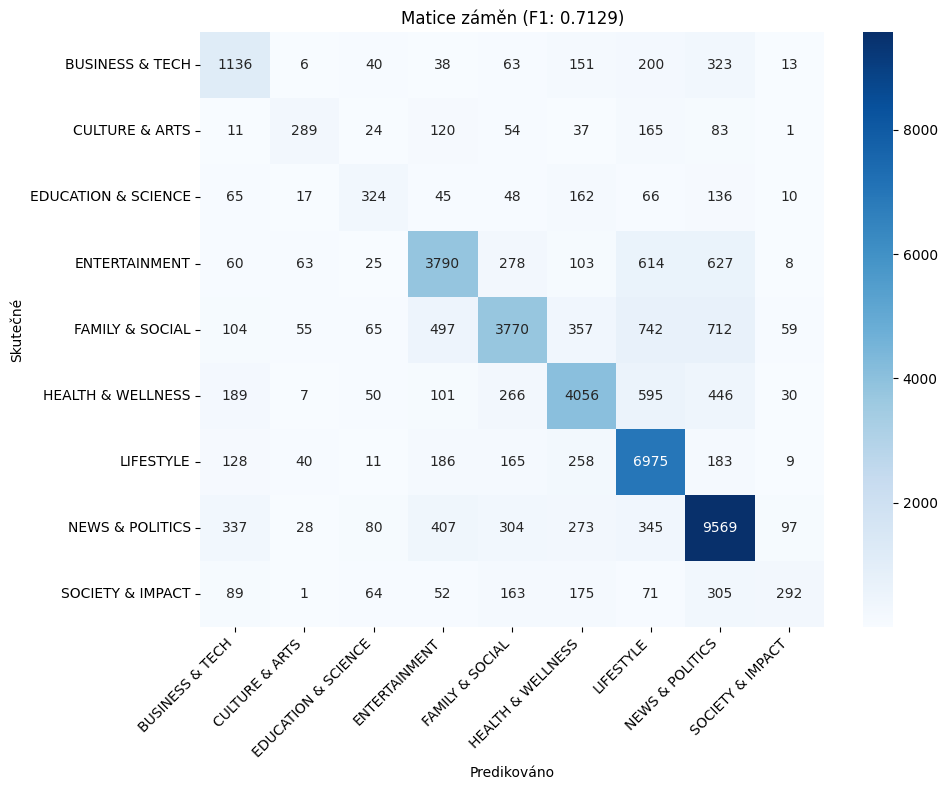

In [52]:
f1_2, report_2 = evaluate_model(model_2, X_test_pad, y_test_cat, label_encoder)

##### Model 3

Tato verze dále rozšiřuje kapacitu předchozího modelu pro zpracování složitějších sekvencí. 🚀

Klíčová vylepšení:
- **Výrazně větší rekurentní vrstvy**: LSTM a GRU nyní s 256 jednotkami → vyšší schopnost modelovat komplexní sekvence. 🧠
- **Rozšířené Dense vrstvy**: Dvě Dense vrstvy s 256 jednotkami → hlubší extrakce příznaků. 📊
- **Zachovaná regularizace**: Tři Dropout vrstvy (0.2) pro udržení generalizace. 🎯

In [53]:
def custom_embedding_3(input_shape, num_classes=9):
	input_layer = Input(shape=input_shape)
	emb = Embedding(VOCAB_SIZE, EMBEDING_DIM)(input_layer)

	x = LSTM(256, activation='relu', return_sequences=True)(emb)
	x = GRU(256, activation='relu', return_sequences=True)(x)

	x = Flatten()(x)
	x = Dense(256, activation='relu')(x)
	x = Dropout(0.2)(x)
	x = Dense(256, activation='relu')(x)
	x = Dropout(0.2)(x)
	x = Dense(128, activation='relu')(x)
	x = Dropout(0.2)(x)

	output = Dense(num_classes, activation='softmax')(x)

	model = Model(input_layer, output)
	model.compile(
			optimizer=RMSprop(),
			loss=CategoricalCrossentropy(from_logits=False),
			metrics=['accuracy']
	)

	return model

In [54]:
model_3 = custom_embedding_3((SEQ_LENGTH,), NUM_CLASSES)
model_3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 128, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128, 256)       │       467,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,351,433 (43.30 MB)

 Trainable params: 11,351,433 (43.30 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
start_time = time.time()
history_3 = model_3.fit(
    X_train_pad, 
    y_train_cat, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]
)
time_taken_3 = time.time() - start_time
print(f"Trénování modelu 3 trvalo {time_taken_3:.2f} sekund.")

Epoch 1/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 215s 98ms/step - accuracy: 0.4357 - loss: 1.5831 - val_accuracy: 0.6705 - val_loss: 1.0391
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 187s 89ms/step - accuracy: 0.7025 - loss: 0.9514 - val_accuracy: 0.7153 - val_loss: 0.9091
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 187s 89ms/step - accuracy: 0.7354 - loss: 0.8414 - val_accuracy: 0.7218 - val_loss: 0.8890
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 300s 143ms/step - accuracy: 0.7548 - loss: 0.7805 - val_accuracy: 0.7269 - val_loss: 0.8860
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 302s 144ms/step - accuracy: 0.7719 - loss: 0.7305 - val_accuracy: 0.7195 - val_loss: 0.9341
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 332s 158ms/step - accuracy: 0.7861 - loss: 0.6855 - val_accuracy: 0.7163 - val_loss: 0.9921
Epoch 7/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 350s 167ms/step - accuracy: 0.8009 - loss: 0.6437 - val_accuracy: 0.7092 - val_loss: 1.1147
Epoch 8/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 333s 159ms/step - accur

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step
F1 skóre (vážené): 0.7186

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.57      0.58      0.58      1970
     CULTURE & ARTS       0.57      0.41      0.47       784
EDUCATION & SCIENCE       0.56      0.37      0.45       873
      ENTERTAINMENT       0.67      0.78      0.72      5568
    FAMILY & SOCIAL       0.73      0.59      0.65      6361
  HEALTH & WELLNESS       0.74      0.70      0.72      5740
          LIFESTYLE       0.79      0.81      0.80      7955
    NEWS & POLITICS       0.75      0.85      0.80     11440
   SOCIETY & IMPACT       0.61      0.26      0.37      1212

           accuracy                           0.73     41903
          macro avg       0.67      0.59      0.62     41903
       weighted avg       0.72      0.73      0.72     41903



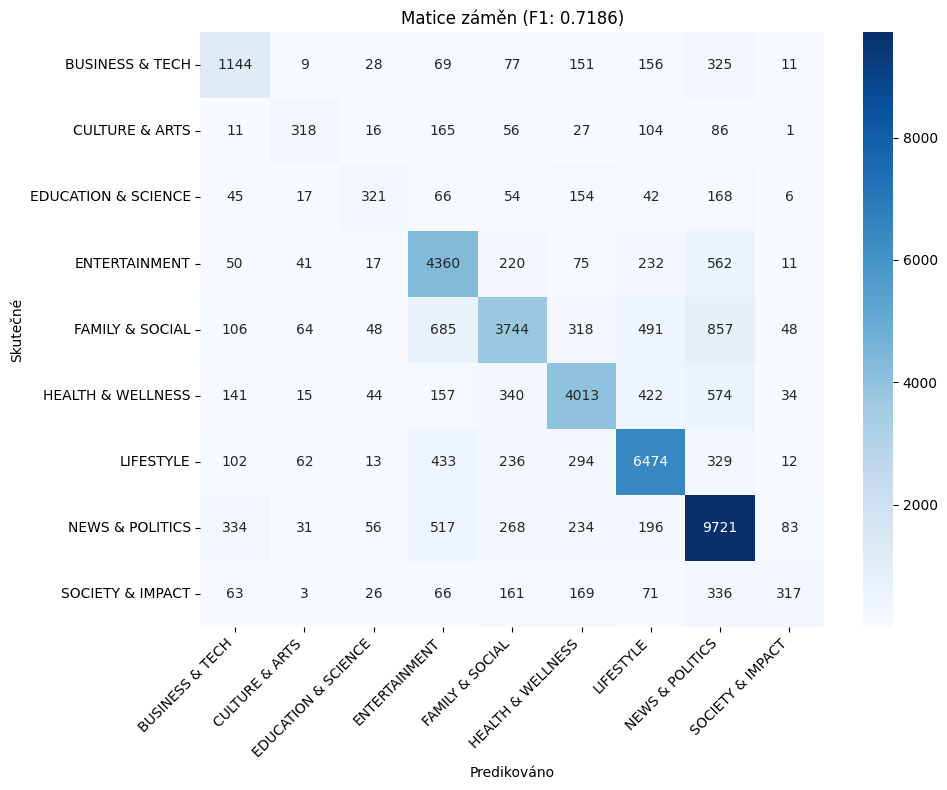

In [56]:
f1_3, report_3 = evaluate_model(model_3, X_test_pad, y_test_cat, label_encoder)

#### GloVe embedding vrstva

##### Model 4

Tento model využívá předtrénované GloVe embeddingy pro reprezentaci slov a zpracování sekvenčních dat. Porovnáme jej s vlastním embedingem.🌟

Stručný popis:
- **Vstup + embedding**: Používá GloVe embeddingy načtené pomocí `glove_im_emb_tokenized()`. 📚
- **Rekurentní vrstvy**: Kombinace LSTM a GRU (oba 64 jednotek) pro zachycení kontextu v sekvenci. 🔄
- **Zpracování výstupu**: Flatten + Dense vrstvy (64 a 32 jednotek) pro extrakci příznaků. 📊
- **Regularizace**: Dropout vrstva (0.2) snižuje riziko přeučení. 🎯
- **Výstupní vrstva**: Softmax klasifikace do počtu tříd `NUM_CLASSES`. 🏷️


In [58]:
def glove_embedding_1():
    input_layer, emb = glove_im_emb_tokenized()
    
    x = LSTM(64, activation='relu', return_sequences=True)(emb)
    x = GRU(64, activation='relu', return_sequences=True)(x)
    
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(input_layer, output)

    model.compile(
        optimizer=RMSprop(),
        loss=CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

In [59]:
model_4 = glove_embedding_1()
model_4.summary()

GloVe vektory: 9812 nalezeno a 187 chybí


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 128, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128, 64)        │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,529 (9.99 MB)

 Trainable params: 619,529 (2.36 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [60]:
start_time = time.time()
history_4 = model_4.fit(
    X_train_pad,
    y_train_cat, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]
)
time_taken_4 = time.time() - start_time
print(f"Trénování modelu 4 trvalo {time_taken_4:.2f} sekund.")

Epoch 1/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 189s 88ms/step - accuracy: 0.4180 - loss: 78689.4219 - val_accuracy: 0.6816 - val_loss: 0.9688
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 187s 89ms/step - accuracy: 0.6856 - loss: 0.9803 - val_accuracy: 0.7104 - val_loss: 0.8826
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 205s 98ms/step - accuracy: 0.7144 - loss: 0.8866 - val_accuracy: 0.7176 - val_loss: 0.8678
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 179s 86ms/step - accuracy: 0.7299 - loss: 0.8507 - val_accuracy: 0.7271 - val_loss: 0.8593
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 130s 62ms/step - accuracy: 0.7385 - loss: 1.5015 - val_accuracy: 0.7183 - val_loss: 1.0810
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 138s 66ms/step - accuracy: 0.7354 - loss: 9.4862 - val_accuracy: 0.7264 - val_loss: 0.8758
Epoch 7/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 140s 64ms/step - accuracy: 0.7401 - loss: 68.3888 - val_accuracy: 0.7248 - val_loss: 0.8910
Epoch 8/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 134s 64ms/step - accur

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
F1 skóre (vážené): 0.7150

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.66      0.49      0.56      1970
     CULTURE & ARTS       0.56      0.36      0.44       784
EDUCATION & SCIENCE       0.54      0.42      0.47       873
      ENTERTAINMENT       0.65      0.76      0.70      5568
    FAMILY & SOCIAL       0.72      0.60      0.66      6361
  HEALTH & WELLNESS       0.71      0.70      0.71      5740
          LIFESTYLE       0.75      0.84      0.80      7955
    NEWS & POLITICS       0.77      0.84      0.80     11440
   SOCIETY & IMPACT       0.64      0.23      0.33      1212

           accuracy                           0.72     41903
          macro avg       0.67      0.58      0.61     41903
       weighted avg       0.72      0.72      0.72     41903



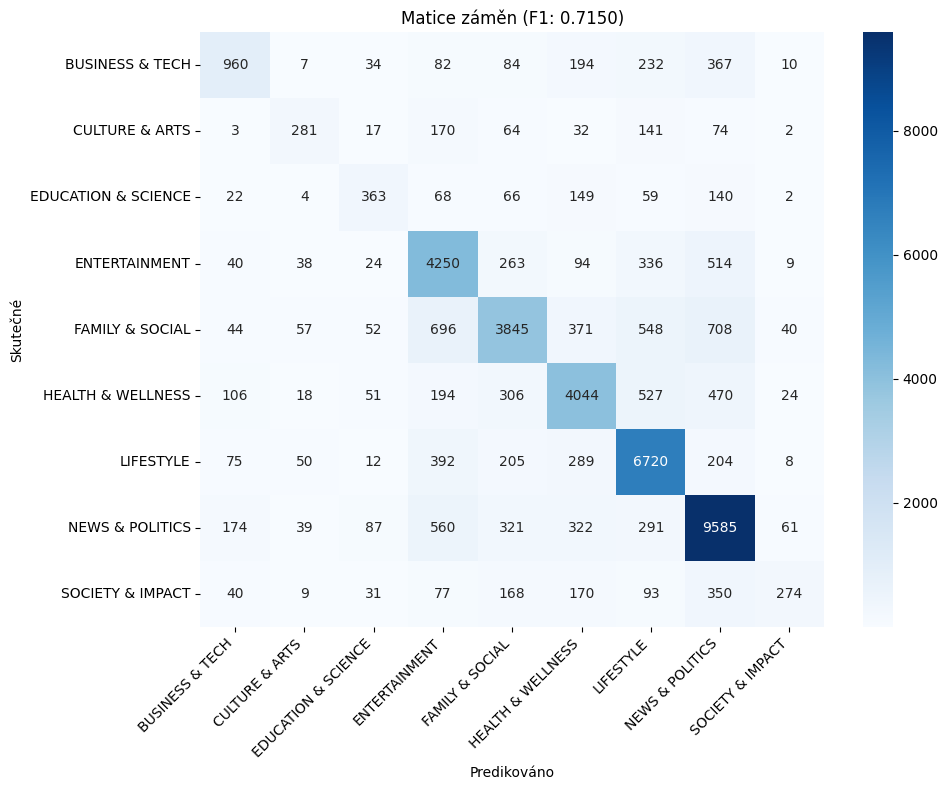

In [61]:
f1_4, report_4 = evaluate_model(model_4, X_test_pad, y_test_cat, label_encoder)

##### Model 5

Tento model rozšiřuje předchozí verzi (`glove_embedding_1`) o vyšší kapacitu a hlubší architekturu. 🚀

Klíčová vylepšení:
- **Silnější rekurentní vrstvy**: LSTM a GRU navýšeny na 128 jednotek → lepší schopnost zachytit složité vzory v datech. 🧠
- **Hlubší Dense blok**: Přidány dvě Dense vrstvy s 128 jednotkami + další s 64 jednotkami → větší prostor pro zpracování příznaků. 📊
- **Zachovaná regularizace**: Dropout (0.2) na konci Dense bloku pro omezení přeučení. 🎯

In [62]:
def glove_embedding_2():
	input_layer, emb = glove_im_emb_tokenized()
	
	x = LSTM(128, activation='relu', return_sequences=True)(emb)
	x = GRU(128, activation='relu', return_sequences=True)(x)

	x = Flatten()(x)
	x = Dense(128, activation='relu')(x)
	x = Dense(128, activation='relu')(x)
	x = Dense(64, activation='relu')(x)
	x = Dropout(0.2)(x)
	
	output = Dense(NUM_CLASSES, activation='softmax')(x)

	model = Model(input_layer, output)
	
	model.compile(
		optimizer=RMSprop(),
		loss=CategoricalCrossentropy(from_logits=False),
		metrics=['accuracy']
	)

	return model

In [63]:
model_5 = glove_embedding_2()
model_5.summary()

GloVe vektory: 9812 nalezeno a 187 chybí


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 128, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128, 128)       │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 128, 128)       │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,390,153 (16.75 MB)

 Trainable params: 2,390,153 (9.12 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [64]:
start_time = time.time()
history_5 = model_5.fit(
    X_train_pad, 
	y_train_cat, 
	epochs=EPOCHS, 
	batch_size=BATCH_SIZE,
	validation_split=VALIDATION_SPLIT,
	callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]
)
time_taken_5 = time.time() - start_time
print(f"Trénování modelu 5 trvalo {time_taken_5:.2f} sekund.")

Epoch 1/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 158s 73ms/step - accuracy: 0.5678 - loss: 7264779.5000 - val_accuracy: 0.7055 - val_loss: 0.9109
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 152s 72ms/step - accuracy: 0.7137 - loss: 41935.7812 - val_accuracy: 0.7237 - val_loss: 0.8515
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 154s 73ms/step - accuracy: 0.7387 - loss: 5499633.5000 - val_accuracy: 0.7263 - val_loss: 0.8487
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 152s 73ms/step - accuracy: 0.7356 - loss: 6806.4795 - val_accuracy: 0.7299 - val_loss: 95.5203
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 152s 72ms/step - accuracy: 0.7264 - loss: 6806.4512 - val_accuracy: 0.7103 - val_loss: 199.3578
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 152s 73ms/step - accuracy: 0.7345 - loss: 43977408.0000 - val_accuracy: 0.6042 - val_loss: 3.6338
Epoch 7/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 156s 74ms/step - accuracy: 0.5985 - loss: 270506475520.0000 - val_accuracy: 0.6936 - val_loss: 2.0541
Epoch 8/10
2096/2096 ━━━━━

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
F1 skóre (vážené): 0.7195

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.62      0.54      0.58      1970
     CULTURE & ARTS       0.44      0.42      0.43       784
EDUCATION & SCIENCE       0.53      0.42      0.47       873
      ENTERTAINMENT       0.69      0.73      0.71      5568
    FAMILY & SOCIAL       0.72      0.62      0.67      6361
  HEALTH & WELLNESS       0.73      0.70      0.71      5740
          LIFESTYLE       0.72      0.87      0.79      7955
    NEWS & POLITICS       0.79      0.81      0.80     11440
   SOCIETY & IMPACT       0.58      0.29      0.39      1212

           accuracy                           0.73     41903
          macro avg       0.65      0.60      0.62     41903
       weighted avg       0.72      0.73      0.72     41903



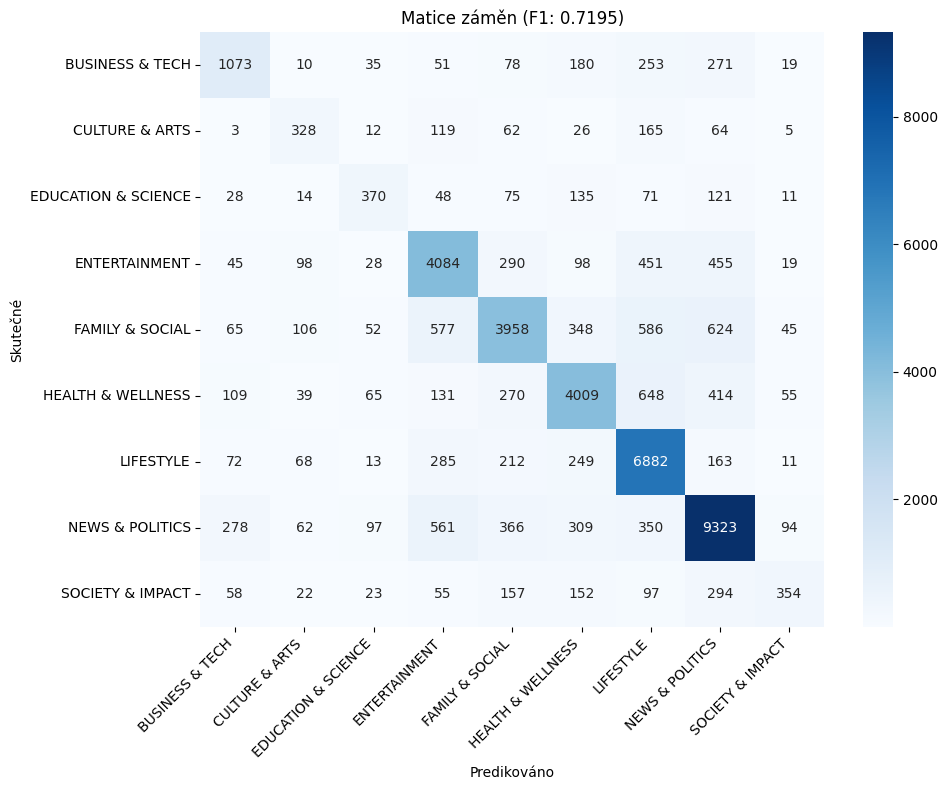

In [65]:
f1_5, report_5 = evaluate_model(model_5, X_test_pad, y_test_cat, label_encoder)

##### Model 6

Tato verze výrazně navyšuje kapacitu modelu a přidává důkladnější regularizaci. 🚀

Klíčová vylepšení:
- **Výrazně větší rekurentní vrstvy**: LSTM a GRU s 256 jednotkami → lepší modelování dlouhodobých závislostí. 🧠
- **Hluboká Dense architektura**: Čtyři Dense vrstvy (256 → 256 → 128 → 64) umožňují detailní zpracování příznaků. 📊
- **Intenzivní regularizace**: Tři Dropout vrstvy (0.2) mezi Dense vrstvami pro snížení rizika přeučení. 🎯

In [66]:
def glove_embedding_3():
	input_layer, emb = glove_im_emb_tokenized()
	
	x = LSTM(256, activation='relu', return_sequences=True)(emb)
	x = GRU(256, activation='relu', return_sequences=True)(x)

	x = Flatten()(x)
	x = Dense(256, activation='relu')(x)
	x = Dropout(0.2)(x)
	x = Dense(256, activation='relu')(x)
	x = Dropout(0.2)(x)
	x = Dense(128, activation='relu')(x)
	x = Dropout(0.2)(x)
	x = Dense(64, activation='relu')(x)
	
	output = Dense(NUM_CLASSES, activation='softmax')(x)

	model = Model(input_layer, output)
	
	model.compile(
		optimizer=RMSprop(),
		loss=CategoricalCrossentropy(from_logits=False),
		metrics=['accuracy']
	)

	return model

In [67]:
model_6 = glove_embedding_3()
model_6.summary()

GloVe vektory: 9812 nalezeno a 187 chybí


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 128, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128, 256)       │       467,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 128, 256)       │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,359,113 (43.33 MB)

 Trainable params: 9,359,113 (35.70 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [68]:
start_time = time.time()
history_6 = model_6.fit(
	X_train_pad, 
	y_train_cat, 
	epochs=EPOCHS, 
	batch_size=BATCH_SIZE,
	validation_split=VALIDATION_SPLIT,
	callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]
)
time_taken_6 = time.time() - start_time
print(f"Trénování modelu 6 trvalo {time_taken_6:.2f} sekund.")

Epoch 1/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 207s 95ms/step - accuracy: 0.5960 - loss: 44.6111 - val_accuracy: 0.7146 - val_loss: 0.8763
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 233s 111ms/step - accuracy: 0.7188 - loss: 10835604.0000 - val_accuracy: 0.7299 - val_loss: 245.7993
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 269s 128ms/step - accuracy: 0.7197 - loss: 4344.6650 - val_accuracy: 0.7224 - val_loss: 9174.2783
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 272s 130ms/step - accuracy: 0.6977 - loss: 4106347085824.0000 - val_accuracy: 0.6351 - val_loss: 1.2023
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 179s 85ms/step - accuracy: 0.7321 - loss: 2202417152.0000 - val_accuracy: 0.7272 - val_loss: 0.8633
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 166s 79ms/step - accuracy: 0.5532 - loss: 2575492.7500 - val_accuracy: 0.7304 - val_loss: 0.8501
Epoch 7/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 167s 80ms/step - accuracy: 0.7419 - loss: 31.8688 - val_accuracy: 0.7251 - val_loss: 0.8930
Epoch 8/10
2096/2096 ━

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
F1 skóre (vážené): 0.7196

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.66      0.47      0.55      1970
     CULTURE & ARTS       0.56      0.39      0.46       784
EDUCATION & SCIENCE       0.51      0.47      0.49       873
      ENTERTAINMENT       0.65      0.78      0.71      5568
    FAMILY & SOCIAL       0.71      0.63      0.67      6361
  HEALTH & WELLNESS       0.73      0.70      0.71      5740
          LIFESTYLE       0.79      0.82      0.80      7955
    NEWS & POLITICS       0.76      0.84      0.80     11440
   SOCIETY & IMPACT       0.59      0.30      0.40      1212

           accuracy                           0.73     41903
          macro avg       0.66      0.60      0.62     41903
       weighted avg       0.72      0.73      0.72     41903



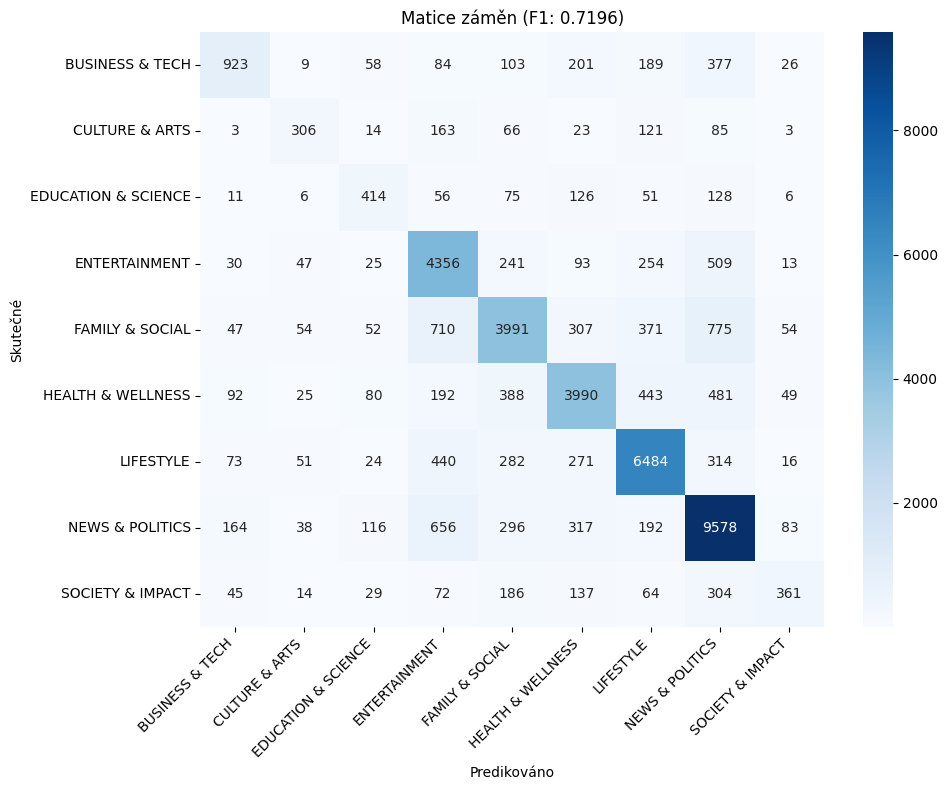

In [69]:
f1_6, report_6 = evaluate_model(model_6, X_test_pad, y_test_cat, label_encoder)

#### Porovnání modelů

##### Overall shrnutí výsledků

In [92]:
all_models_comparison = pd.DataFrame({
	"Model": ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"],
	"Embedding": ["Custom", "Custom", "Custom", "GloVe", "GloVe", "GloVe"],
	"F1 Score": [f1_1, f1_2, f1_3, f1_4, f1_5, f1_6],
	"Doba trénování (s)": [time_taken_1, time_taken_2, time_taken_3, time_taken_4, time_taken_5, time_taken_6],
	"Doba trénování (min)": [time_taken_1/60, time_taken_2/60, time_taken_3/60, time_taken_4/60, time_taken_5/60, time_taken_6/60],
	"Dokončené epochy": [len(history_1.history['loss']), len(history_2.history['loss']), len(history_3.history['loss']), 
						 len(history_4.history['loss']), len(history_5.history['loss']), len(history_6.history['loss'])],
	"Parametry": [model_1.count_params(), model_2.count_params(), model_3.count_params(), 
				 model_4.count_params(), model_5.count_params(), model_6.count_params()],
	"Velikost (MB)": [model_1.count_params() * 4 / (1024 * 1024), 
					 model_2.count_params() * 4 / (1024 * 1024), 
					 model_3.count_params() * 4 / (1024 * 1024),
					 model_4.count_params() * 4 / (1024 * 1024),
					 model_5.count_params() * 4 / (1024 * 1024),
					 model_6.count_params() * 4 / (1024 * 1024)]
})

all_models_comparison["F1 Score"] = all_models_comparison["F1 Score"].map("{:.4f}".format)
all_models_comparison["Doba trénování (min)"] = all_models_comparison["Doba trénování (min)"].map("{:.2f}".format)
all_models_comparison["Doba trénování (s)"] = all_models_comparison["Doba trénování (s)"].map("{:.2f}".format)
all_models_comparison["Velikost (MB)"] = all_models_comparison["Velikost (MB)"].map("{:.2f}".format)

In [137]:
all_models_comparison

Model Embedding F1 Score Doba trénování (s) Doba trénování (min)  \
0  Model 1    Custom   0.7205            1634.83                27.25   
1  Model 2    Custom   0.7129            1314.82                21.91   
2  Model 3    Custom   0.7186            2554.78                42.58   
3  Model 4     GloVe   0.7150            1438.89                23.98   
4  Model 5     GloVe   0.7195            1229.74                20.50   
5  Model 6     GloVe   0.7196            2170.50                36.17   

   Dokončené epochy  Parametry Velikost (MB)  
0                10    2619529          9.99  
1                 8    4390153         16.75  
2                 9   11351433         43.30  
3                 9    2619529          9.99  
4                 8    4390153         16.75  
5                10   11359113         43.33

In [89]:
f1_scores = [float(score) for score in all_models_comparison["F1 Score"]]
best_model_idx = np.argmax(f1_scores)
best_model = all_models_comparison["Model"].iloc[best_model_idx]
best_embedding = all_models_comparison["Embedding"].iloc[best_model_idx]
best_f1 = all_models_comparison["F1 Score"].iloc[best_model_idx]

print(f"\nNejlepší model celkově: {best_model} s {best_embedding} embedding (F1 = {best_f1})")

custom_mask = all_models_comparison["Embedding"] == "Custom"
glove_mask = all_models_comparison["Embedding"] == "GloVe"

custom_f1_scores = [float(score) for score in all_models_comparison.loc[custom_mask, "F1 Score"]]
best_custom_idx = np.argmax(custom_f1_scores)
best_custom = all_models_comparison.loc[custom_mask, "Model"].iloc[best_custom_idx]
best_custom_f1 = all_models_comparison.loc[custom_mask, "F1 Score"].iloc[best_custom_idx]

glove_f1_scores = [float(score) for score in all_models_comparison.loc[glove_mask, "F1 Score"]]
best_glove_idx = np.argmax(glove_f1_scores)
best_glove = all_models_comparison.loc[glove_mask, "Model"].iloc[best_glove_idx]
best_glove_f1 = all_models_comparison.loc[glove_mask, "F1 Score"].iloc[best_glove_idx]

print(f"Nejlepší model s Custom embedding: {best_custom} (F1 = {best_custom_f1})")
print(f"Nejlepší model s GloVe embedding: {best_glove} (F1 = {best_glove_f1})")


Nejlepší model celkově: Model 1 s Custom embedding (F1 = 0.7205)
Nejlepší model s Custom embedding: Model 1 (F1 = 0.7205)
Nejlepší model s GloVe embedding: Model 6 (F1 = 0.7196)


Celkově jsou vlastní embedding vrstvy mírně přesnější, ale GloVe embeddingy nabízejí lepší efektivitu z hlediska času trénování. Pro produkční nasazení by byl pravděpodobně nejvhodnější **Model 5**, který kombinuje dobrou přesnost (0.7195) s přijatelnou velikostí (16.75 MB) a nejkratší dobou trénování. ✨

Pro další experimenty zvolíme embedding vrstvu **GloVe** a model **5**, který se ukázal jako nejefektivnější z hlediska přesnosti a doby trénování, a zkusíme jej dále vylepšit. 🔬

#### Pokročilé modely

##### Model 7 - obousměrná LSTM vrstva

Tento model využívá obousměrnou rekurentní vrstvy pro lepší zachycení kontextu v obou směrech sekvence. 🔄

Klíčové vlastnosti:
- **GloVe embeddingy**: Předtrénované vektorové reprezentace slov. 📚
- **Bidirekcionální LSTM a GRU**: Obousměrné zpracování sekvence pomocí 128 jednotek → lepší porozumění kontextu zleva i zprava. 🧠
- **Dense blok**: Tři vrstvy (128 → 128 → 64) pro extrakci a zpracování příznaků. 📊
- **Dropout (0.2)**: Regularizace pro omezení přeučení. 🎯
- **Výstup**: Softmax klasifikace do `NUM_CLASSES`. 🏷️

In [97]:
def advanced_model_1():
    input_layer, emb = glove_im_emb_tokenized()
    
    x = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(emb)
    x = Bidirectional(GRU(128, activation='relu', return_sequences=True))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(input_layer, output)
    
    model.compile(
        optimizer=RMSprop(),
        loss=CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

In [98]:
model_7 = advanced_model_1()
model_7.summary()

GloVe vektory: 9812 nalezeno a 187 chybí


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 128, 200)       │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128, 256)       │       336,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128, 256)       │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,853,129 (26.14 MB)

 Trainable params: 4,853,129 (18.51 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [99]:
start_time = time.time()
history_7 = model_7.fit(
	X_train_pad, 
	y_train_cat, 
	epochs=EPOCHS, 
	batch_size=BATCH_SIZE,
	validation_split=VALIDATION_SPLIT,
	callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]
)
time_taken_7 = time.time() - start_time
print(f"Trénování modelu 7 trvalo {time_taken_7:.2f} sekund.")

Epoch 1/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 314s 145ms/step - accuracy: 0.6165 - loss: 1.1813 - val_accuracy: 0.7074 - val_loss: 0.9065
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 299s 143ms/step - accuracy: 0.7251 - loss: 0.8625 - val_accuracy: 0.7313 - val_loss: 0.8395
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 323s 154ms/step - accuracy: 0.7471 - loss: 4.5943 - val_accuracy: 0.7313 - val_loss: 4.3251
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 356s 170ms/step - accuracy: 0.7599 - loss: 97633.2891 - val_accuracy: 0.7308 - val_loss: 55.4135
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 349s 167ms/step - accuracy: 0.7671 - loss: 32203.9492 - val_accuracy: 0.7234 - val_loss: 1.3307
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 342s 163ms/step - accuracy: 0.7639 - loss: 2065.5798 - val_accuracy: 0.7268 - val_loss: 3.5404
Epoch 7/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 339s 162ms/step - accuracy: 0.7075 - loss: 333680476160.0000 - val_accuracy: 0.7129 - val_loss: 507478.5312
Trénování modelu 7 trvalo 2322.18 

1310/1310 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step
F1 skóre (vážené): 0.7215

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.66      0.49      0.56      1970
     CULTURE & ARTS       0.55      0.39      0.45       784
EDUCATION & SCIENCE       0.59      0.39      0.47       873
      ENTERTAINMENT       0.67      0.77      0.72      5568
    FAMILY & SOCIAL       0.69      0.65      0.67      6361
  HEALTH & WELLNESS       0.74      0.69      0.71      5740
          LIFESTYLE       0.78      0.83      0.81      7955
    NEWS & POLITICS       0.76      0.84      0.80     11440
   SOCIETY & IMPACT       0.62      0.25      0.36      1212

           accuracy                           0.73     41903
          macro avg       0.67      0.59      0.62     41903
       weighted avg       0.72      0.73      0.72     41903



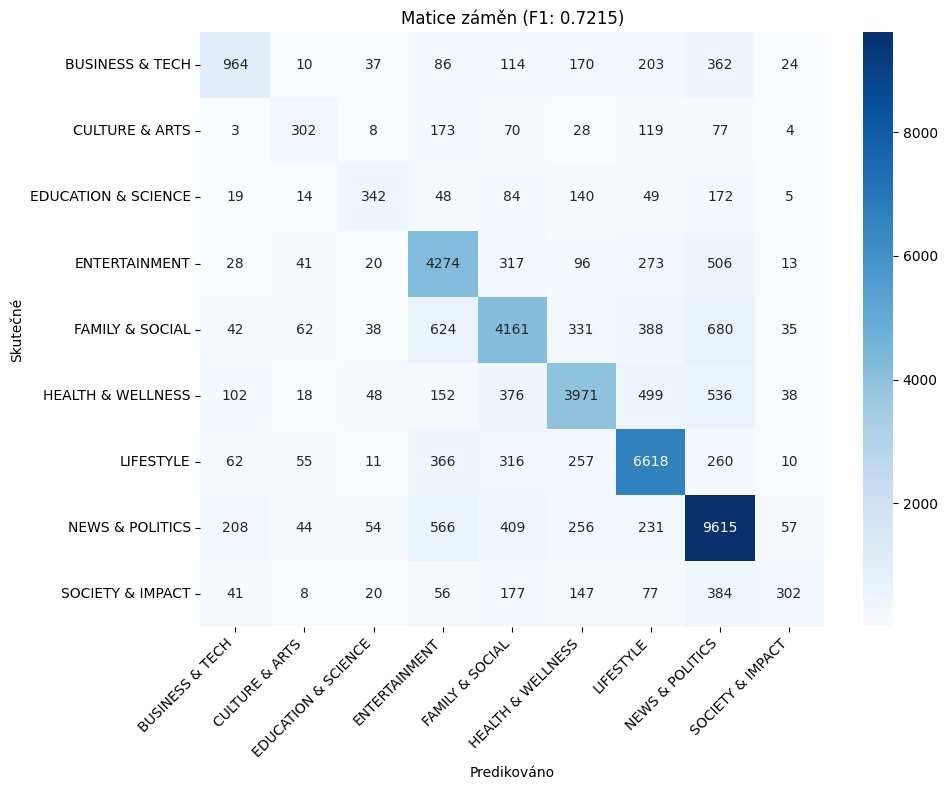

In [100]:
f1_7, report_7 = evaluate_model(model_7, X_test_pad, y_test_cat, label_encoder)

In [101]:
print(f"F1 skóre modelu 5: {f1_5:.4f}")
print(f"F1 skóre modelu 7: {f1_7:.4f}")

F1 skóre modelu 5: 0.7195
F1 skóre modelu 7: 0.7215


Máme lepší výsledek než u modelu 5. Jdeme správným směrem. 🚀 

Využili jsme pouze 7 z 10 epoch, což naznačuje brzké přeučení modelu. 

##### Model 8 - Attetnion mechanismus

Tento model rozšiřuje předchozí verzi o mechanismus attention, který zvýrazňuje důležité části vstupní sekvence. ✨

Klíčové vlastnosti:
- **GloVe embeddingy**: Předtrénované slovní vektory pro vstupní reprezentaci. 📚
- **Bidirekcionální LSTM a GRU**: Zpracování sekvence v obou směrech pomocí 128 jednotek → komplexnější pochopení kontextu. 🔄
- **Attention mechanismus**: 
	- Vypočítává váhy důležitosti pro jednotlivé časové kroky. 🎯
	- Zvýrazňuje relevantní části výstupu GRU. 🔍
	- Výsledkem je souhrnný kontextový vektor. 🧠
- **Hluboký Dense blok**: Čtyři vrstvy (256 → 128 → 128 → 64) pro sofistikované zpracování příznaků. 📊
- **Dropout (0.3)**: Silnější regularizace pro prevenci přeučení. 🚀
- **Výstup**: Softmax klasifikace do `NUM_CLASSES`. 🏷️

In [ ]:
def advanced_model_2():
	input_layer, emb = glove_im_emb_tokenized()
	
	lstm_out = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(emb)
	gru_out = Bidirectional(GRU(128, activation='relu', return_sequences=True))(lstm_out)
	
	# Attention mechanism
	attention = TimeDistributed(Dense(1))(gru_out)  # vrstva pro výpočet attention skóre
	attention = Reshape((SEQ_LENGTH,))(attention)  # Převod na tvar (SEQ_LENGTH,)
	
	# Použití vrstvy Softmax z Keras místo tf.nn.softmax, která je kompatibilní s Keras
	attention = Softmax(axis=1)(attention)  # Normalizace attention skóre
	
	attention = Reshape((SEQ_LENGTH, 1))(attention)  # Převod na tvar (SEQ_LENGTH, 1)
	
	attended_gru = Multiply()([gru_out, attention])  # Element-wise násobení pro vážení výstupu GRU
	
	# Součet vážených vektorů pomocí vrstvy Lambda z Keras, nutné pro kompatibilitu s Keras
	context_vector = Lambda(lambda x: K.sum(x, axis=1))(attended_gru)
	
	x = Dense(256, activation='relu')(context_vector)
	x = Dense(128, activation='relu')(x)
	x = Dense(128, activation='relu')(x)
	x = Dense(64, activation='relu')(x)
	x = Dropout(0.3)(x)  
	
	output = Dense(NUM_CLASSES, activation='softmax')(x)
	
	model = Model(input_layer, output)
	
	model.compile(
		optimizer=RMSprop(learning_rate=0.001),
		loss=CategoricalCrossentropy(from_logits=False),
		metrics=['accuracy']
	)
	return model

In [111]:
model_8 = advanced_model_2()
model_8.summary()

GloVe vektory: 9812 nalezeno a 187 chybí


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 128, 200)  │  2,000,000 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_10    │ (None, 128, 256)  │    336,896 │ embedding_11[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 128, 256)  │    296,448 │ bidirectional_10… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 128, 1)    │        257 │ bidirectional_11… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 128)       │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 128)       │          0 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 128, 1)    │          0 │ softmax_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 128, 256)  │          0 │ bidirectional_11… │
│ (Multiply)          │                   │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256)       │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 256)       │     65,792 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 128)       │     32,896 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 128)       │     16,512 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      8,256 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 9)         │        585 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,757,642 (10.52 MB)

 Trainable params: 757,642 (2.89 MB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [112]:
start_time = time.time()
history_8 = model_8.fit(
    X_train_pad, 
	y_train_cat, 
	epochs=EPOCHS, 
	batch_size=BATCH_SIZE,
	validation_split=VALIDATION_SPLIT,
	callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]
)
time_taken_8 = time.time() - start_time
print(f"Trénování modelu 8 trvalo {time_taken_8:.2f} sekund.")

Epoch 1/10


2025-06-02 20:17:11.824156: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_reverse_slice_fusion', 4888 bytes spill stores, 4884 bytes spill loads



2096/2096 ━━━━━━━━━━━━━━━━━━━━ 470s 210ms/step - accuracy: 0.5676 - loss: 146704224.0000 - val_accuracy: 0.7007 - val_loss: 0.9316
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 401s 166ms/step - accuracy: 0.7143 - loss: 1.3424 - val_accuracy: 0.7184 - val_loss: 3.8671
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 351s 167ms/step - accuracy: 0.6269 - loss: 877236977664.0000 - val_accuracy: 0.5168 - val_loss: 1.4571
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 352s 168ms/step - accuracy: 0.5221 - loss: 28134606897152.0000 - val_accuracy: 0.5213 - val_loss: 1.4373
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 367s 158ms/step - accuracy: 0.5249 - loss: 36011673387008.0000 - val_accuracy: 0.5197 - val_loss: 1.4326
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 343s 164ms/step - accuracy: 0.5251 - loss: 27058004557824.0000 - val_accuracy: 0.5182 - val_loss: 1.4569
Trénování modelu 8 trvalo 2283.77 sekund.


1310/1310 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step
F1 skóre (vážené): 0.6898

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.57      0.52      0.55      1970
     CULTURE & ARTS       0.54      0.32      0.40       784
EDUCATION & SCIENCE       0.53      0.36      0.43       873
      ENTERTAINMENT       0.61      0.78      0.68      5568
    FAMILY & SOCIAL       0.69      0.60      0.64      6361
  HEALTH & WELLNESS       0.75      0.61      0.67      5740
          LIFESTYLE       0.70      0.86      0.77      7955
    NEWS & POLITICS       0.78      0.78      0.78     11440
   SOCIETY & IMPACT       0.62      0.17      0.27      1212

           accuracy                           0.70     41903
          macro avg       0.64      0.56      0.58     41903
       weighted avg       0.70      0.70      0.69     41903



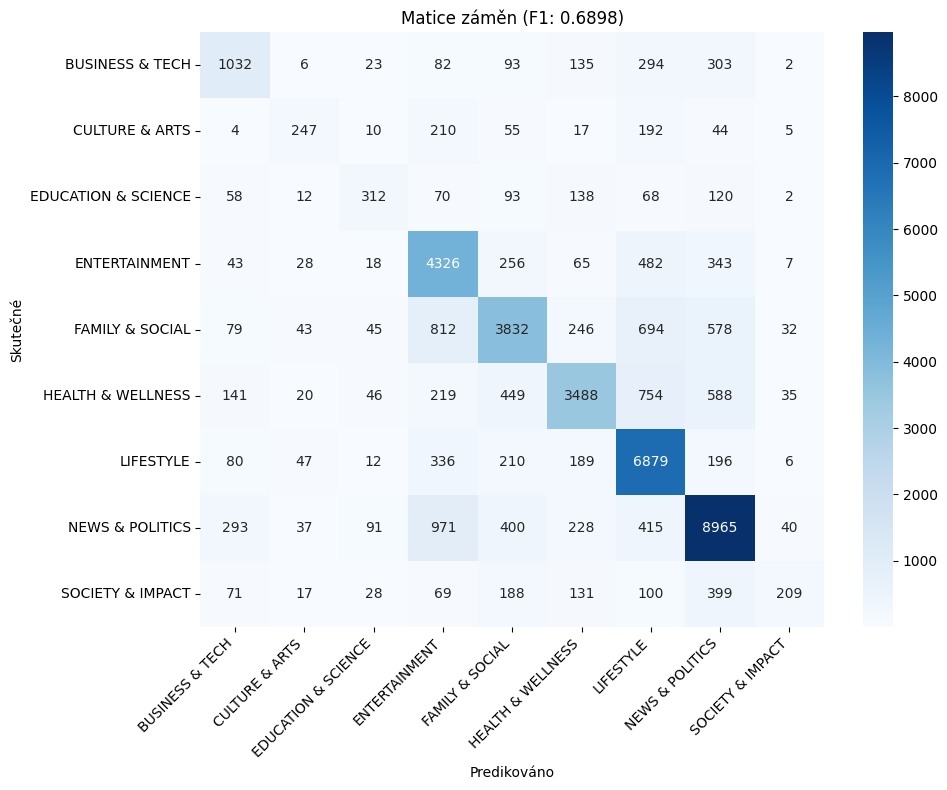

In [113]:
f1_8, report_8 = evaluate_model(model_8, X_test_pad, y_test_cat, label_encoder)

In [115]:
print(f"F1 skóre modelu 5: {f1_5:.4f}")
print(f"F1 skóre modelu 7: {f1_7:.4f}")
print(f"F1 skóre modelu 8: {f1_8:.4f}")

F1 skóre modelu 5: 0.7195
F1 skóre modelu 7: 0.7215
F1 skóre modelu 8: 0.6898


Okey, Attention vrstva zřejmě nefunguje úplně tak, jak bychom si představovali. 🤔💭

Došlo k brzkému přeučení modelu a zastavení trénování po 6 epochách. F1 skóre je sice vyšší než u modelu 7, ale stále nedosahuje očekávaných hodnot.

##### Model 9 - All in One

Model `advanced_model_3` je vylepšenou verzí modelu `advanced_model_1` a přináší několik zásadních architektonických vylepšení pro lepší zachycení kontextu a zvýšení výkonnosti. 🚀

🔧 Hlavní zlepšení oproti `advanced_model_1`:
- 🧠 **Silnější rekurentní vrstvy**: Zvýšený počet jednotek (192 vs. 128) v obousměrných LSTM a GRU vrstvách.
- 🧪 **Normalizace**: Zavedení `LayerNormalization` po každé rekurentní vrstvě pro stabilnější trénink.
- 📊 **Pokročilé agregace**: Místo zploštění výstupu využívá kombinaci `GlobalAveragePooling1D` a `GlobalMaxPooling1D`, což efektivněji zachycuje celkový kontext.
- 🛠️ **Moderní Dense blok**: Více vrstev s `BatchNormalization`, `LeakyReLU` a vyšší dropout → vyšší kapacita a lepší regularizace.
- 🧮 **Nižší learning rate**: Jemněji laděný optimalizátor pro stabilnější konvergenci.

In [ ]:
def advanced_model_3():
	input_layer, emb = glove_im_emb_tokenized()
	
	lstm_out = Bidirectional(LSTM(192, activation='relu', return_sequences=True))(emb)
	lstm_out = LayerNormalization()(lstm_out)
	
	gru_out = Bidirectional(GRU(192, activation='relu', return_sequences=True))(lstm_out)
	gru_out = LayerNormalization()(gru_out)

	# Globální pooling místo attention
	avg_pool = GlobalAveragePooling1D()(gru_out)
	max_pool = GlobalMaxPooling1D()(gru_out)
	context_vector = Concatenate()([avg_pool, max_pool])
	
	# Více vrstev s Batch Normalization, LeakyReLU a Dropout
	x = Dense(512)(context_vector)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.1)(x)
	x = Dropout(0.35)(x)
	
	x = Dense(384)(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.1)(x)
	x = Dropout(0.3)(x)
	
	x = Dense(256)(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.1)(x)
	x = Dropout(0.25)(x)
	
	x = Dense(128)(x)
	x = BatchNormalization()(x)
	x = LeakyReLU(alpha=0.1)(x)
	
	output = Dense(NUM_CLASSES, activation='softmax')(x)
	
	model = Model(input_layer, output)
	model.compile(
		optimizer=RMSprop(learning_rate=0.0005),
		loss=CategoricalCrossentropy(from_logits=False),
		metrics=['accuracy']
	)
	
	return model


In [132]:
model_9 = advanced_model_3()
model_9.summary()

GloVe vektory: 9812 nalezeno a 187 chybí


/home/vojte/.virtualenvs/hluboke-uceni/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_17        │ (None, 128, 200)  │  2,000,000 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_27    │ (None, 128, 384)  │    603,648 │ embedding_17[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 384)  │        768 │ bidirectional_27… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_28    │ (None, 128, 384)  │    665,856 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 384)  │        768 │ bidirectional_28… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 384)       │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 768)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 512)       │    393,728 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_60[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 512)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 512)       │          0 │ leaky_re_lu_10[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_61 (Dense)    │ (None, 384)       │    196,992 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384)       │      1,536 │ dense_61[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_11      │ (None, 384)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 384)       │          0 │ leaky_re_lu_11[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,999,497 (15.26 MB)

 Trainable params: 1,996,937 (7.62 MB)

 Non-trainable params: 2,002,560 (7.64 MB)

In [133]:
start_time = time.time()
history_9 = model_9.fit(
    X_train_pad, 
	y_train_cat, 
	epochs=EPOCHS, 
	batch_size=BATCH_SIZE,
	validation_split=VALIDATION_SPLIT,
	callbacks=[EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)]
)
time_taken_9 = time.time() - start_time
print(f"Trénování modelu 9 trvalo {time_taken_9:.2f} sekund.")

Epoch 1/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 358s 163ms/step - accuracy: 0.6299 - loss: 1.1307 - val_accuracy: 0.7206 - val_loss: 0.8354
Epoch 2/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 351s 168ms/step - accuracy: 0.7218 - loss: 0.8425 - val_accuracy: 0.7344 - val_loss: 0.8036
Epoch 3/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 367s 175ms/step - accuracy: 0.7504 - loss: 0.7522 - val_accuracy: 0.7269 - val_loss: 0.8398
Epoch 4/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 370s 177ms/step - accuracy: 0.7738 - loss: 0.6794 - val_accuracy: 0.7250 - val_loss: 0.8653
Epoch 5/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 375s 179ms/step - accuracy: 0.7977 - loss: 0.6054 - val_accuracy: 0.7245 - val_loss: 0.9395
Epoch 6/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 379s 181ms/step - accuracy: 0.8240 - loss: 0.5238 - val_accuracy: 0.7144 - val_loss: 1.0148
Epoch 7/10
2096/2096 ━━━━━━━━━━━━━━━━━━━━ 379s 181ms/step - accuracy: 0.8469 - loss: 0.4532 - val_accuracy: 0.7147 - val_loss: 1.1295
Trénování modelu 9 trvalo 2580.31 sekund.


1310/1310 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step
F1 skóre (vážené): 0.7271

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.60      0.57      0.58      1970
     CULTURE & ARTS       0.55      0.39      0.45       784
EDUCATION & SCIENCE       0.53      0.43      0.48       873
      ENTERTAINMENT       0.69      0.74      0.72      5568
    FAMILY & SOCIAL       0.74      0.62      0.67      6361
  HEALTH & WELLNESS       0.72      0.72      0.72      5740
          LIFESTYLE       0.78      0.85      0.81      7955
    NEWS & POLITICS       0.77      0.84      0.81     11440
   SOCIETY & IMPACT       0.57      0.31      0.40      1212

           accuracy                           0.73     41903
          macro avg       0.66      0.61      0.63     41903
       weighted avg       0.73      0.73      0.73     41903



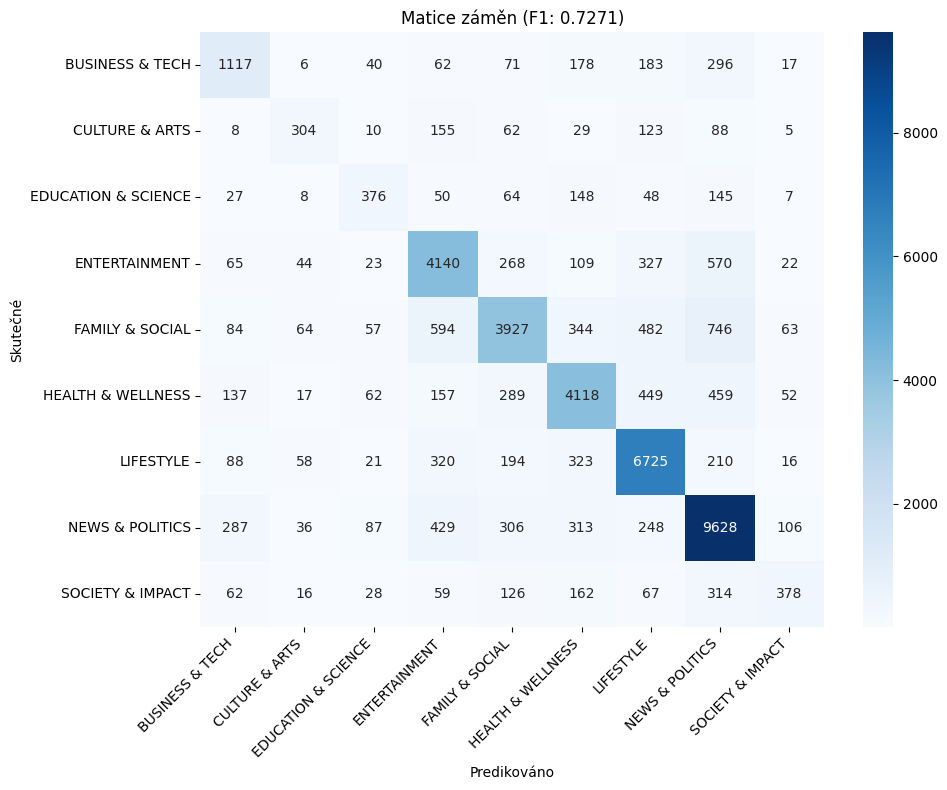

In [134]:
f1_9, report_9 = evaluate_model(model_9, X_test_pad, y_test_cat, label_encoder)

In [136]:
print(f"F1 skóre modelu 5: {f1_5:.4f}")
print(f"F1 skóre modelu 7: {f1_7:.4f}")
print(f"F1 skóre modelu 8: {f1_8:.4f}")
print(f"F1 skóre modelu 9: {f1_9:.4f}")

F1 skóre modelu 5: 0.7195
F1 skóre modelu 7: 0.7215
F1 skóre modelu 8: 0.6898
F1 skóre modelu 9: 0.7271


Paráda! Zlepšení vidíme, vše si popíšeme v závěru.

### Předem natrénované modely

#### Funkce pro tokenizaci a přípravu dat

In [193]:
def tokenize_data(texts, labels, tokenizer, max_length):
    encodings = tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        to_categorical(labels, num_classes=NUM_CLASSES)
    ))
    return dataset

#### Parametry pro trénování modelů

In [ ]:
BATCH_SIZE = 32 # změněno z 64 na 16 pro kompatibilitu s GPU
EPOCHS = 5 # změněno z 10 na 5 pro rychlejší trénink
steps_per_epoch = len(X_train) // BATCH_SIZE
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1 * num_train_steps)

#### Model 10 - TinyBERT

Protože nechci trénovat modely několik hodin po jedné epoše, našel jsem si odloučený model **TinyBERT**. Tento model je menší a rychlejší verze BERTu, která je vhodná pro mobilní zařízení a aplikace s omezenými zdroji. 🚀

Měl by zápasit na stejné úrovni jako originální BERT, ale s menšími nároky na výpočetní výkon a paměť. 🧠

In [229]:
tinybert_tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
tinybert_model = TFBertForSequenceClassification.from_pretrained("huawei-noah/TinyBERT_General_4L_312D", num_labels=NUM_CLASSES, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['fit_denses.0.weight', 'fit_denses.4.weight', 'fit_denses.2.bias', 'fit_denses.4.bias', 'fit_denses.0.bias', 'fit_denses.3.bias', 'fit_denses.3.weight', 'fit_denses.1.bias', 'fit_denses.1.weight', 'fit_denses.2.weight']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classif

##### Trénovací a testovací data pro TinyBERT

In [230]:
train_dataset = tokenize_data(X_train, y_train_encoded, tinybert_tokenizer, SEQ_LENGTH).batch(BATCH_SIZE)
test_dataset = tokenize_data(X_test, y_test_encoded, tinybert_tokenizer, SEQ_LENGTH).batch(BATCH_SIZE)

##### Optimalizér & ztrátová funkce

In [231]:
optimizer, _ = create_optimizer(
    init_lr=5e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps
)

tinybert_model.compile(
    optimizer=optimizer,  
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

##### Trénování modelu

In [232]:
start_time = time.time()
history_10 = tinybert_model.fit(
	train_dataset,
	epochs=EPOCHS
)
time_taken_10 = time.time() - start_time
print(f"Trénování TinyBERT modelu trvalo {time_taken_10:.2f} sekund.")

Epoch 1/5
5238/5238 [==============================] - 638s 119ms/step - loss: 1.0947 - accuracy: 0.6427
Epoch 2/5
5238/5238 [==============================] - 636s 121ms/step - loss: 0.7128 - accuracy: 0.7650
Epoch 3/5
5238/5238 [==============================] - 591s 113ms/step - loss: 0.5947 - accuracy: 0.8035
Epoch 4/5
5238/5238 [==============================] - 578s 110ms/step - loss: 0.5079 - accuracy: 0.8334
Epoch 5/5
5238/5238 [==============================] - 564s 108ms/step - loss: 0.4487 - accuracy: 0.8527
Trénování TinyBERT modelu trvalo 3007.30 sekund.


##### Vyhodnocení modelu

In [234]:
test_pred_raw = tinybert_model.predict(test_dataset)
y_pred_proba = tf.nn.softmax(test_pred_raw.logits).numpy()
y_pred = np.argmax(y_pred_proba, axis=1)

1310/1310 [==============================] - 66s 50ms/step


2025-06-03 00:22:37.550637: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


F1 skóre: 0.7590

Klasifikační zpráva:
                     precision    recall  f1-score   support

    BUSINESS & TECH       0.64      0.60      0.62      1970
     CULTURE & ARTS       0.55      0.51      0.53       784
EDUCATION & SCIENCE       0.60      0.53      0.56       873
      ENTERTAINMENT       0.74      0.77      0.76      5568
    FAMILY & SOCIAL       0.73      0.69      0.71      6361
  HEALTH & WELLNESS       0.73      0.75      0.74      5740
          LIFESTYLE       0.83      0.84      0.84      7955
    NEWS & POLITICS       0.81      0.84      0.83     11440
   SOCIETY & IMPACT       0.50      0.45      0.48      1212

           accuracy                           0.76     41903
          macro avg       0.68      0.66      0.67     41903
       weighted avg       0.76      0.76      0.76     41903



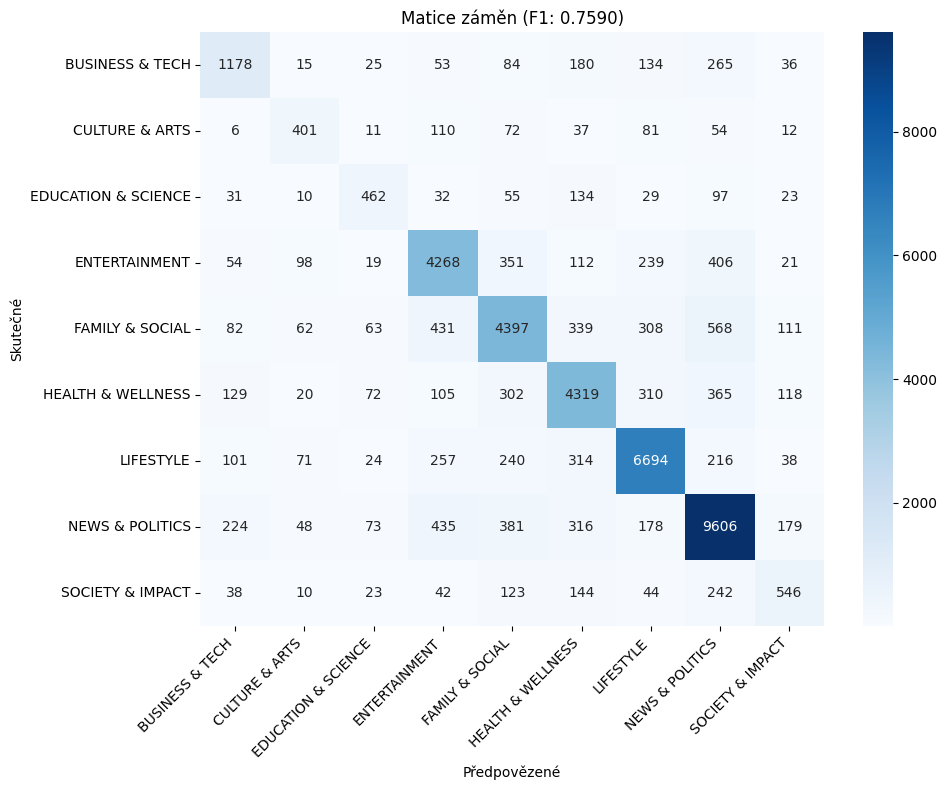

In [236]:
y_true = []
for _, labels in test_dataset.unbatch():
	y_true.append(np.argmax(labels.numpy()))
y_true = np.array(y_true)

f1_10 = f1_score(y_true, y_pred, average='weighted')
report_10 = classification_report(
	y_true, 
	y_pred, 
	target_names=label_encoder.classes_,
	zero_division=0
)

print(f"F1 skóre: {f1_10:.4f}")
print("\nKlasifikační zpráva:")
print(report_10)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
			xticklabels=label_encoder.classes_,
			yticklabels=label_encoder.classes_)
plt.xlabel('Předpovězené')
plt.ylabel('Skutečné')
plt.title(f'Matice záměn (F1: {f1_10:.4f})')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Závěr

## Vlastní vs GloVe embeddingy

In [135]:
all_models_comparison

Model Embedding F1 Score Doba trénování (s) Doba trénování (min)  \
0  Model 1    Custom   0.7205            1634.83                27.25   
1  Model 2    Custom   0.7129            1314.82                21.91   
2  Model 3    Custom   0.7186            2554.78                42.58   
3  Model 4     GloVe   0.7150            1438.89                23.98   
4  Model 5     GloVe   0.7195            1229.74                20.50   
5  Model 6     GloVe   0.7196            2170.50                36.17   

   Dokončené epochy  Parametry Velikost (MB)  
0                10    2619529          9.99  
1                 8    4390153         16.75  
2                 9   11351433         43.30  
3                 9    2619529          9.99  
4                 8    4390153         16.75  
5                10   11359113         43.33

Výsledky modelů 🎯

Vždy jsme se dostali na **F1 skóre nad 0.71**, což je následek sloučení kategorií a použití vhodných embedding vrstev. Kvůli nerovnoměrnému rozložení kategorií a jejich nízkému počtu článků se budeme pohybovat v tomto rozmezí a naším cilem bude přesáhnout F1 skóre 0.72. 

1. **Přesnost klasifikace (F1 skóre)** 📊:
	- Nejvyšší F1 skóre dosáhl **Model 1** s vlastní embedding vrstvou (0.7205) 🏆
	- U modelů s GloVe embeddingy byl nejúspěšnější **Model 6** (0.7196) 🌟
	- Rozdíly v přesnosti mezi modely jsou relativně malé (v rozmezí 0.7129 - 0.7205)

2. **Výpočetní náročnost** ⏱️:
	- Nejrychleji se trénoval **Model 5** s GloVe embeddingem (20.50 min) ⚡
	- Časově nejnáročnější byl **Model 3** s vlastní embedding vrstvou (42.58 min) 🕒
	- GloVe modely byly obecně rychlejší než ekvivalentní modely s vlastním embeddingem

3. **Velikost modelů** 💾:
	- Nejmenší modely (Model 1 a 4) mají shodně ~10 MB 📦
	- Nejrozsáhlejší modely (Model 3 a 6) mají shodně ~43 MB 🏗️
	- Zvyšování komplexity modelů přímo úměrně zvyšuje jejich velikost

4. **Poměr výkon/náročnost** 🚀:
	- **Model 1** nabízí nejlepší poměr výkonu (nejvyšší F1) a velikosti (pouze 10 MB) 🥇
	- **Model 5** poskytuje nejlepší poměr výkonu a doby trénování 🥈

### Vizualizace výsledků

#### F1 skóre podle embedding vrstvy

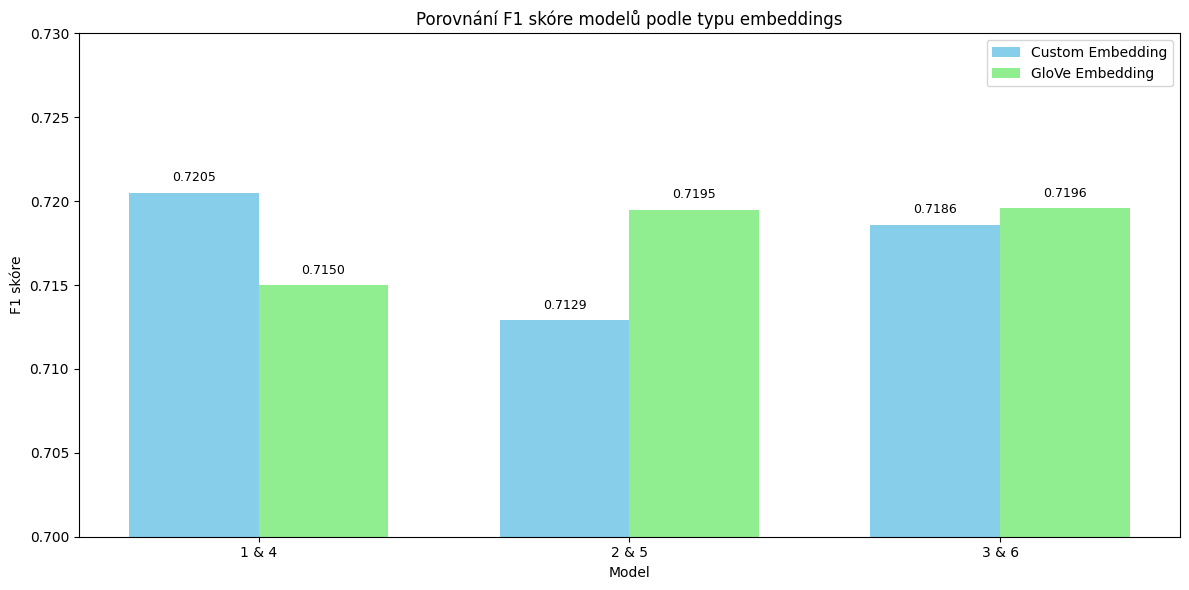

In [138]:
plt.figure(figsize=(12, 6))

f1_scores = [float(score) for score in all_models_comparison["F1 Score"]]

custom_models = ["Model 1", "Model 2", "Model 3"]
glove_models = ["Model 4", "Model 5", "Model 6"]
custom_f1 = np.array(f1_scores[0:3])
glove_f1 = np.array(f1_scores[3:6])

x = np.arange(3)  # 3 pairs of models
width = 0.35

custom_bars = plt.bar(x - width/2, custom_f1, width, color='skyblue', label='Custom Embedding')
glove_bars = plt.bar(x + width/2, glove_f1, width, color='lightgreen', label='GloVe Embedding')

plt.xlabel('Model')
plt.ylabel('F1 skóre')
plt.title('Porovnání F1 skóre modelů podle typu embeddings')
plt.xticks(x, ["1 & 4", "2 & 5", "3 & 6"])
plt.ylim(0.70, 0.73)
plt.legend()

for bar in custom_bars:
	height = bar.get_height()
	plt.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
			 f'{height:.4f}', ha='center', va='bottom', fontsize=9)

for bar in glove_bars:
	height = bar.get_height()
	plt.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
			 f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### Doba trénování modelů podle embedding vrstvy

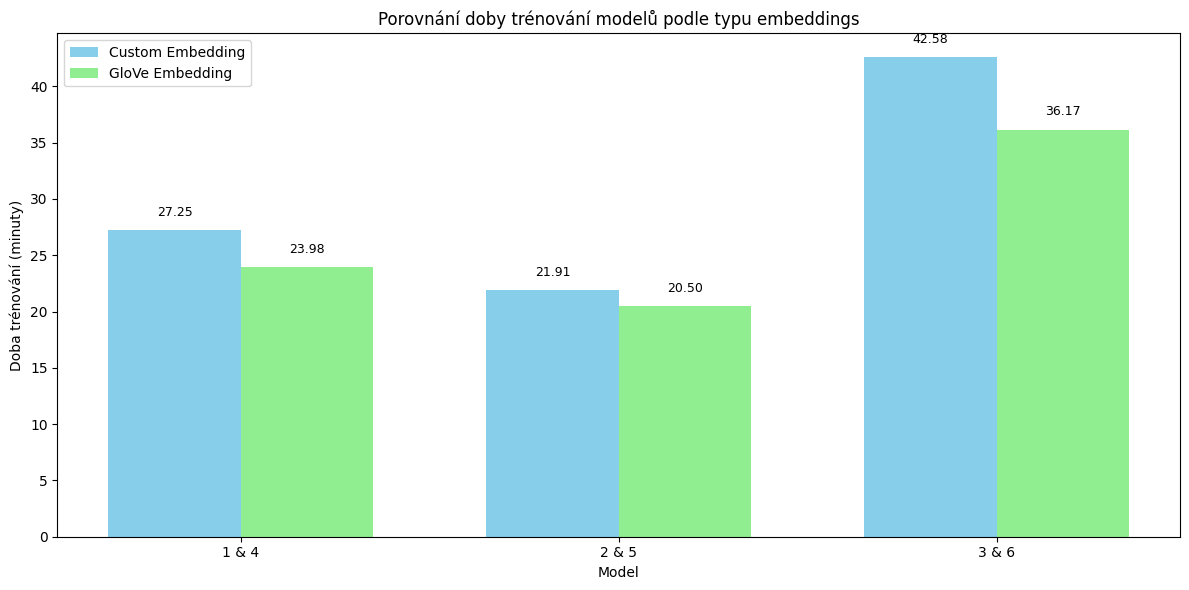

In [139]:
plt.figure(figsize=(12, 6))

training_times = [float(time) for time in all_models_comparison["Doba trénování (min)"]]

custom_models = ["Model 1", "Model 2", "Model 3"]
glove_models = ["Model 4", "Model 5", "Model 6"]
custom_times = np.array(training_times[0:3])
glove_times = np.array(training_times[3:6])

x = np.arange(3)  # 3 pairs of models
width = 0.35

custom_time_bars = plt.bar(x - width/2, custom_times, width, color='skyblue', label='Custom Embedding')
glove_time_bars = plt.bar(x + width/2, glove_times, width, color='lightgreen', label='GloVe Embedding')

plt.xlabel('Model')
plt.ylabel('Doba trénování (minuty)')
plt.title('Porovnání doby trénování modelů podle typu embeddings')
plt.xticks(x, ["1 & 4", "2 & 5", "3 & 6"])
plt.legend()

for bar in custom_time_bars:
	height = bar.get_height()
	plt.text(bar.get_x() + bar.get_width()/2., height + 1,
			 f'{height:.2f}', ha='center', va='bottom', fontsize=9)

for bar in glove_time_bars:
	height = bar.get_height()
	plt.text(bar.get_x() + bar.get_width()/2., height + 1,
			 f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## Pokročilé modely

In [ ]:
all_models_comparison_2 = pd.DataFrame({
	"Model": ["Model 5", "Model 7", "Model 8", "Model 9"],
	"Embedding": ["GloVe", "GloVe", "GloVe", "GloVe"],
	"F1 Score": [f1_5, f1_7, f1_8, f1_9],
	"Doba trénování (s)": [time_taken_5, time_taken_7, time_taken_8, time_taken_9],
	"Doba trénování (min)": [time_taken_5/60, time_taken_7/60, time_taken_8/60, time_taken_9/60],
	"Dokončené epochy": [len(history_5.history['loss']), len(history_7.history['loss']), len(history_8.history['loss']), len(history_9.history['loss'])],
	"Parametry": [model_5.count_params(), model_7.count_params(), model_8.count_params(), model_9.count_params()],
	"Velikost (MB)": [model_5.count_params() * 4 / (1024 * 1024), 
					 model_7.count_params() * 4 / (1024 * 1024), 
					 model_8.count_params() * 4 / (1024 * 1024),
					 model_9.count_params() * 4 / (1024 * 1024)]
})

all_models_comparison_2["F1 Score"] = all_models_comparison_2["F1 Score"].map("{:.4f}".format)
all_models_comparison_2["Doba trénování (min)"] = all_models_comparison_2["Doba trénování (min)"].map("{:.2f}".format)
all_models_comparison_2["Doba trénování (s)"] = all_models_comparison_2["Doba trénování (s)"].map("{:.2f}".format)
all_models_comparison_2["Velikost (MB)"] = all_models_comparison_2["Velikost (MB)"].map("{:.2f}".format)
all_models_comparison_2

Model Embedding F1 Score Doba trénování (s) Doba trénování (min)  \
0  Model 5     GloVe   0.7195            1229.74                20.50   
1  Model 7     GloVe   0.7215            2322.18                38.70   
2  Model 8     GloVe   0.6898            2283.77                38.06   
3  Model 9     GloVe   0.7271            2580.31                43.01   

   Dokončené epochy  Parametry Velikost (MB)  
0                 8    4390153         16.75  
1                 7    6853129         26.14  
2                 6    2757642         10.52  
3                 7    3999497         15.26

### Závěr výsledků modelů 🚀

1. **Nejlepší model celkově** 🏆  
	- **Model 9** dosáhl nejvyššího F1 skóre **0.7271**.  
	- Kombinuje vysokou přesnost s přijatelnou velikostí **15.26 MB** a rozumnou dobou trénování **43.01 min**.  

2. **Nejrychlejší model** ⚡  
	- **Model 5** byl nejrychlejší s dobou trénování **20.50 min**.  
	- Přesto si udržel solidní F1 skóre **0.7195** a velikost **16.75 MB**.  

3. **Nejmenší model** 📦  
	- **Model 8** byl nejmenší s velikostí **10.52 MB**, ale jeho F1 skóre **0.6898** bylo nejnižší.  
	- Tento model by mohl být vhodný pro aplikace s omezenými zdroji, kde není klíčová maximální přesnost.  

4. **Model s nejlepším poměrem výkonu a velikosti** 🎯  
	- **Model 7** nabídl skvělý kompromis mezi přesností (**0.7215**) a velikostí (**26.14 MB**).  
	- Je vhodný pro scénáře, kde je důležitá vysoká přesnost, ale velikost modelu není kritickým faktorem.  

Vyvození závěrů a volba nejvhodnějšího modelu ✨  
- **Pro produkční nasazení**: Doporučujeme **Model 9**, který nabízí nejlepší přesnost a přijatelnou velikost.  
- **Pro rychlé iterace**: **Model 5** je ideální díky rychlému trénování a solidní přesnosti.  
- **Pro omezené zdroje**: **Model 8** je vhodný díky své malé velikosti, ale je třeba zvážit nižší přesnost.  

🎉 Celkově jsme dosáhli skvělých výsledků s GloVe embeddingy a různými architekturami modelů!

### Vizualizace výsledků

#### F1 skóre

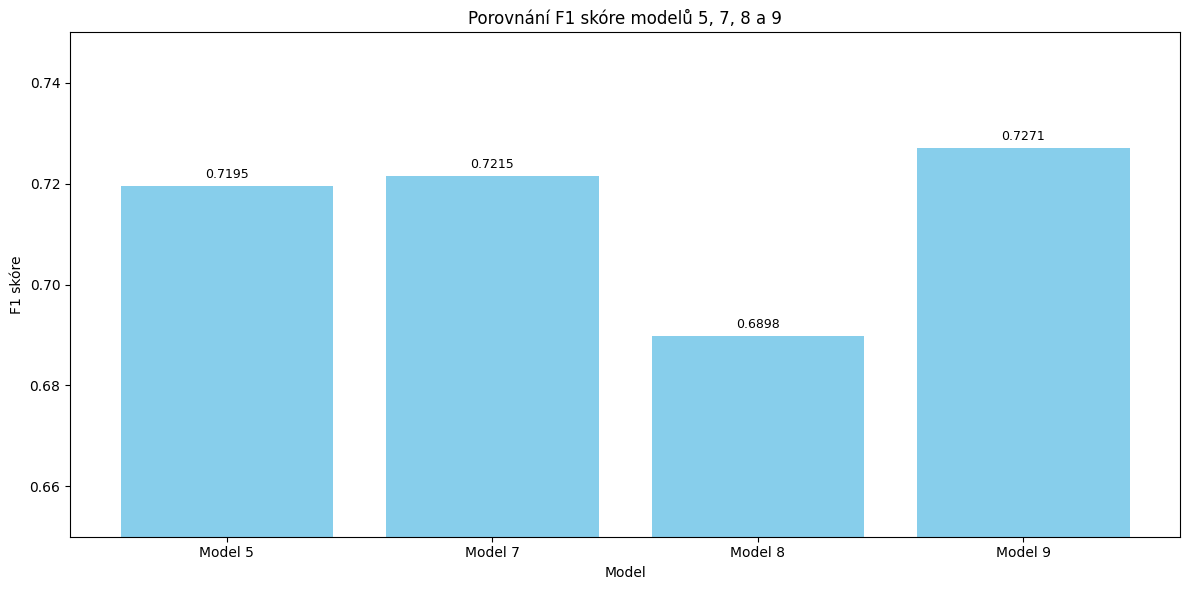

In [ ]:
plt.figure(figsize=(12, 6))
f1_scores_2 = [float(score) for score in all_models_comparison_2["F1 Score"]]
plt.bar(all_models_comparison_2["Model"], f1_scores_2, color='skyblue')
plt.xlabel('Model')
plt.ylabel('F1 skóre')
plt.title('Porovnání F1 skóre modelů 5, 7, 8 a 9')
for i, score in enumerate(f1_scores_2):
	plt.text(i, score + 0.001, f'{score:.4f}', ha='center', va='bottom', fontsize=9)
plt.ylim(0.65, 0.75)
plt.tight_layout()
plt.show()

#### Délka trénování

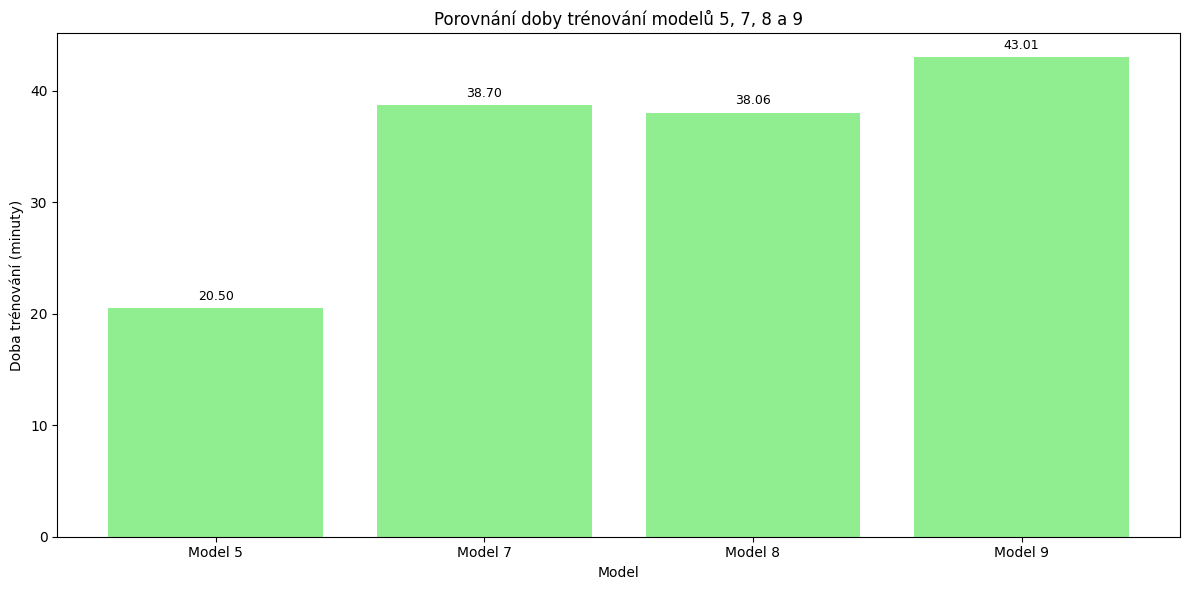

In [ ]:
plt.figure(figsize=(12, 6))
training_times_2 = [float(time) for time in all_models_comparison_2["Doba trénování (min)"]]
plt.bar(all_models_comparison_2["Model"], training_times_2, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Doba trénování (minuty)')
plt.title('Porovnání doby trénování modelů 5, 7, 8 a 9')
for i, time in enumerate(training_times_2):
	plt.text(i, time + 0.5, f'{time:.2f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()

## Předem natrénované modely - TinyBERT

In [ ]:
print(f"Počet parametrů TinyBERT modelu: {tinybert_model.count_params()}")
print(f"Velikost TinyBERT modelu (MB): {tinybert_model.count_params() * 4 / (1024 * 1024):.2f}")
print(f"F1 skóre TinyBERT modelu: {f1_10:.4f}")
print(f"Doba trénování TinyBERT modelu (s): {time_taken_10:.2f}")
print(f"Doba trénování TinyBERT modelu (min): {time_taken_10 / 60:.2f}")

Počet parametrů TinyBERT modelu: 14353065
Velikost TinyBERT modelu (MB): 54.75
F1 skóre TinyBERT modelu: 0.7590
Doba trénování TinyBERT modelu (s): 3007.30
Doba trénování TinyBERT modelu (min): 50.12


TinyBERT model se ukázal jako skutečný šampion mezi všemi testovanými modely, a to i přes svou relativně malou velikost a nízký počet parametrů. Na polovině epoch tento model přinesl několik klíčových výhod.

Vlastnosti modelu:
- 🧠 **Počet parametrů**: 14,353,065  
	- TinyBERT má výrazně méně parametrů než většina ostatních modelů
- 💾 **Velikost modelu**: 54.75 MB  
	- I přes svou malou velikost dokáže TinyBERT dosáhnout špičkových výsledků
- 🎯 **F1 skóre**: 0.7590  
	- TinyBERT překonal všechny ostatní modely v přesnosti,
- ⏱️ **Doba trénování**: 3007.30 s (50.12 min)  
	- I přes delší dobu trénování ve srovnání s některými jinými modely je výsledná přesnost TinyBERT více než dostatečnou kompenzací.

🔥 **TinyBERT dokázal, že i "malý" model může dosáhnout velkých výsledků!** 🏆

## Vše dohromady

### Tabulka všech

In [ ]:
all_models_comparison_final = pd.DataFrame({
	"Model": ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6", 
			  "Model 7", "Model 8", "Model 9", "TinyBERT"],
	"Embedding": ["Custom", "Custom", "Custom", "GloVe", "GloVe", "GloVe",
				  "GloVe", "GloVe", "GloVe", "TinyBERT"],
	"F1 Score": [f1_1, f1_2, f1_3, f1_4, f1_5, f1_6, f1_7, f1_8, f1_9, f1_10],
	"Doba trénování (s)": [time_taken_1, time_taken_2, time_taken_3, 
						   time_taken_4, time_taken_5, time_taken_6,
						   time_taken_7, time_taken_8, time_taken_9, time_taken_10],
	"Doba trénování (min)": [time_taken_1/60, time_taken_2/60, time_taken_3/60,
							 time_taken_4/60, time_taken_5/60, time_taken_6/60,
							 time_taken_7/60, time_taken_8/60, time_taken_9/60,
							 time_taken_10/60],
	"Dokončené epochy": [len(history_1.history['loss']), len(history_2.history['loss']),
						len(history_3.history['loss']), len(history_4.history['loss']),
						len(history_5.history['loss']), len(history_6.history['loss']),
						len(history_7.history['loss']), len(history_8.history['loss']),
						len(history_9.history['loss']), len(history_10.history['loss'])],
	"Parametry": [model.count_params() for model in [model_1, model_2, model_3,
													  model_4, model_5, model_6,
													  model_7, model_8, model_9,
													  tinybert_model]],
	"Velikost (MB)": [model.count_params() * 4 / (1024 * 1024) for model in
					 [model_1, model_2, model_3, model_4, model_5, model_6,
					  model_7, model_8, model_9, tinybert_model]]
})
all_models_comparison_final["F1 Score"] = all_models_comparison_final["F1 Score"].map("{:.4f}".format)
all_models_comparison_final["Doba trénování (min)"] = all_models_comparison_final["Doba trénování (min)"].map("{:.2f}".format)
all_models_comparison_final["Doba trénování (s)"] = all_models_comparison_final["Doba trénování (s)"].map("{:.2f}".format)
all_models_comparison_final["Velikost (MB)"] = all_models_comparison_final["Velikost (MB)"].map("{:.2f}".format)
all_models_comparison_final

Model Embedding F1 Score Doba trénování (s) Doba trénování (min)  \
0   Model 1    Custom   0.7205            1634.83                27.25   
1   Model 2    Custom   0.7129            1314.82                21.91   
2   Model 3    Custom   0.7186            2554.78                42.58   
3   Model 4     GloVe   0.7150            1438.89                23.98   
4   Model 5     GloVe   0.7195            1229.74                20.50   
5   Model 6     GloVe   0.7196            2170.50                36.17   
6   Model 7     GloVe   0.7215            2322.18                38.70   
7   Model 8     GloVe   0.6898            2283.77                38.06   
8   Model 9     GloVe   0.7271            2580.31                43.01   
9  TinyBERT  TinyBERT   0.7590            3007.30                50.12   

   Dokončené epochy  Parametry Velikost (MB)  
0                10    2619529          9.99  
1                 8    4390153         16.75  
2                 9   11351433         43.30  
3                 9    2619529          9.99  
4                 8    4390153         16.75  
5                10   11359113         43.33  
6                 7    6853129         26.14  
7                 6    2757642         10.52  
8                 7    3999497         15.26  
9                 5   14353065         54.75

### F1 skóre

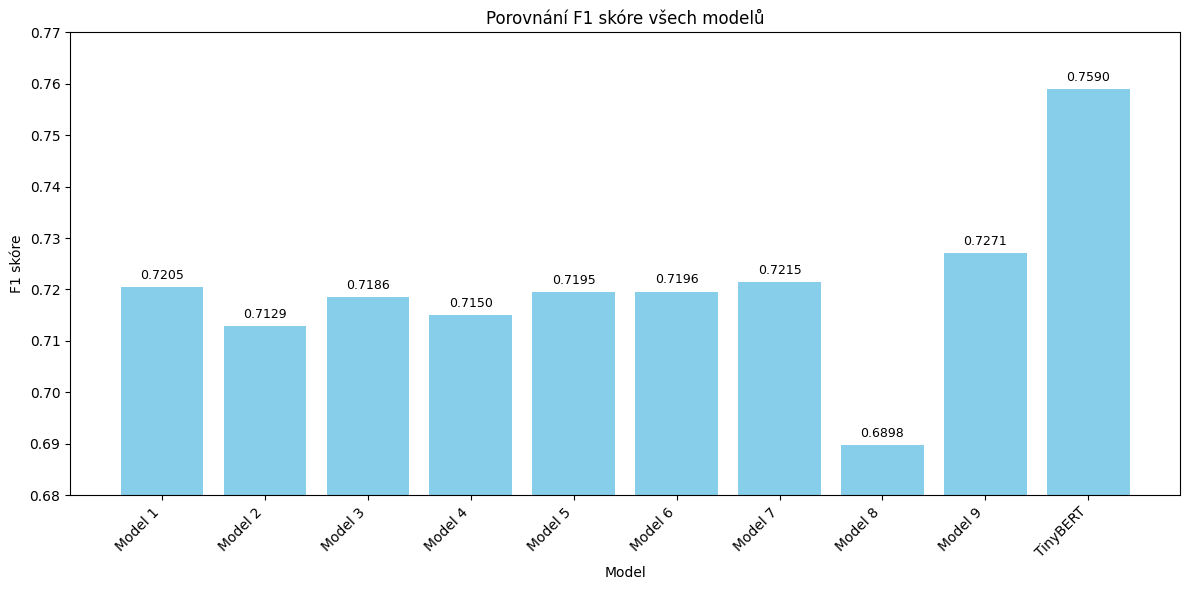

In [243]:
plt.figure(figsize=(12, 6))

f1_scores_final = [float(score) for score in all_models_comparison_final["F1 Score"]]
plt.bar(all_models_comparison_final["Model"], f1_scores_final, color='skyblue')
plt.xlabel('Model')
plt.ylabel('F1 skóre')
plt.title('Porovnání F1 skóre všech modelů')
for i, score in enumerate(f1_scores_final):
	plt.text(i, score + 0.001, f'{score:.4f}', ha='center', va='bottom', fontsize=9)
plt.ylim(0.68, 0.77)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Doba trénování

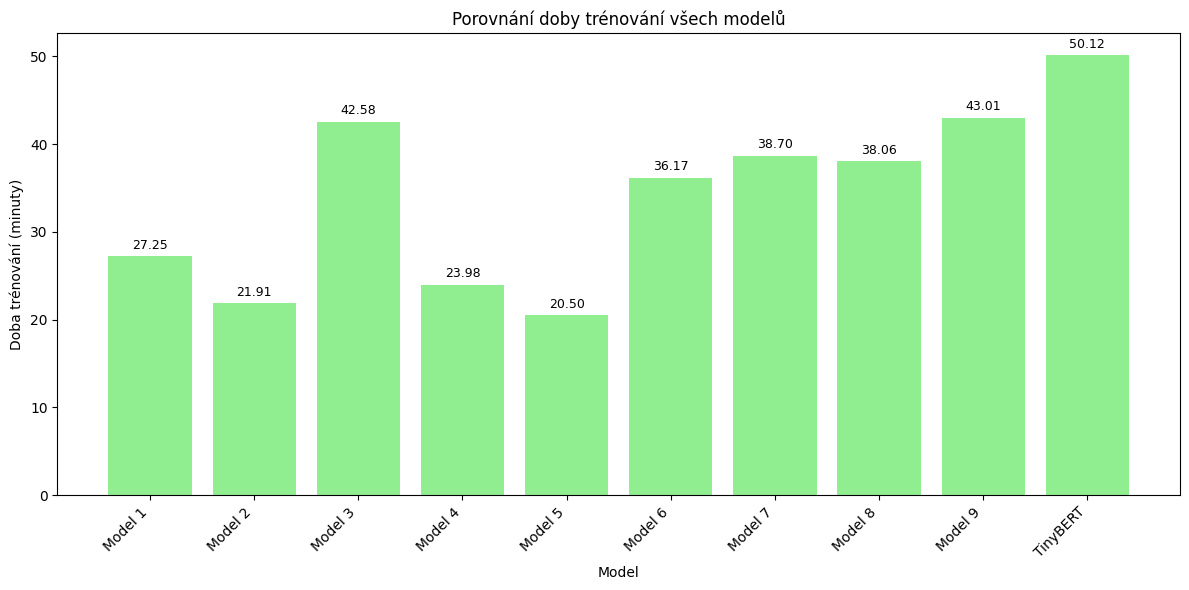

In [ ]:
plt.figure(figsize=(12, 6))

training_times_final = [float(time) for time in all_models_comparison_final["Doba trénování (min)"]]
plt.bar(all_models_comparison_final["Model"], training_times_final, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Doba trénování (minuty)')
plt.title('Porovnání doby trénování všech modelů')
for i, time in enumerate(training_times_final):
	plt.text(i, time + 0.5, f'{time:.2f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()